# ASTR3110 Computer Laboratory 2: Determining star cluster membership with Gaia data and Gaussian Mixuture Modelling.

In this lab, you will again make use of data from the Gaia Data Release 3 (Gaia DR3). This time you will use the position (R.A., decl.), proper motions (pmRA, pmdec), and distance measurements from Gaia to identify open clusters using Gaussian Mixture Modelling (GMM). You will also identify which stars in the data are most likely gravitationally bound members of the clusters. By identifying which stars in a region of sky belong to different star clusters, it is possible to investigate the properties of the open clusters such as their kinematics, stellar populations etc.

In the first part of the lab, you will download and then get to know your data, eliminating spurious data points using the techniques you learned in Lab 1, as well as performing task-specific filtering of the data. Then, you will explore the data by producing a series of plots that will help you better understand the data, and will also guide your decision making for future analysis.

In the second part of the lab, you will begin to use the [scikit learn GMM package](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to identify star clusters in the data. This will require an amount of experimentation, which will help you to become familiar with using the GMM. You will refine your analysis to a point where you can isolate the clusters in the data and use the GMM fits to determine the stars with the greatest likelihood of being gravtitationally bound members of those clusters.

Finally, you will plot separate colour-magnitude diagrams for the clusters you have found in the data.

<font color='red'> Checkpoints for where you should aim to be up to at the end of each lab are highlighted in red throughout the notebook.</font>

At the completion of this lab, you will have acquired (or improved) the following skills:
- Data filtering using Pandas.
- Manipulating data to derive required parameters.
- Plotting data and interpreting plots using matplotlib and seaborn.
- Using scikit learn Gaussian Mixture Modelling.

# Submission and Rubric

This lab is worth **20%** of your final grade. You will be required to submit **two separate files** via iLearn (see the lab submission portal in the Assessments tab) by 11:55pm Friday 10th May 2024. The files are:

1. **Your Colab notebook containing your code (i.e., the LAB2FILENAME.ipynb notebook).** We will randomly select code cells to inspect and will mark them based on the following criteria, each worth **10 marks**:
    - **Comments: Your code must be commented and your comments should demonstrate that you understand what your code is doing, and why! You can insert comments by either adding explanation text placed in blocks just before code blocks OR as comments within the code blocks themselves. The marking rubric is as follows:**

            8.5-10: Thorough comments that clearly explain what and why, demonstrating excellent understanding of code.
            7.5-8.5: Comments that explain what and mostly why, demonstrate good understanding.
            6.5-7.5: Comments that mostly explain what, not why, mostly demonstrate understanding.
            5.0-6.5: Some comments explaining what or why, some demonstration of understanding.
            < 5.0: Minimal comments.

    - **Formatting of your code. Rubric:**

            8.5-10: Code is clear and easy to understand with sensible variable names.
            7.5-8.5: Mostly clear, understandable with semi-sensible variable names.
            6.5-7.5: Code is understandable OR good variable names.
            5-6.5: Some effort in formatting code OR using sensible variable names.
            < 5.: Spaghetti code, remnants of code bits that failed to run.

2. **A document (preferrably in pdf format) that contains the plots, answers to questions, and explanation requests <font color='blue'>highlighted in blue throughout the notebook.</font>** We will mark those based on the following criteria, again worth **10 marks** each:
    - **Plots: Your plots should be well presented and explained. Rubric:**

            8.5-10: All requested plots are included and are accompanied by a caption that thoroughly explains them and details what they show and why plotted. Plots have clear symbols, clearly labeled axes, and axis ranges are set so that trends visible.
            7.5-8.5: All requested plots included and accompanied by captions that mostly explain what and why. Plots include good labels, ranges, and symbols.
            6.5-7.5: Most requested plots are included and captions mostly explain what. Good labels, ranges, and symbols.
            5-6.5: Most requested plots included, captions contain some explanation. Adequate labels, ranges, and symbols.
            < 5.0: Many missing plots, minimal effort in explaining or making sure plots/labels are clear.

    - **Comments and answers to any questions posed in the notebooks as well as comments on interpretation/comparison of results. Rubric:**

            8.5-10: Correct, detailed answers and comments for all questions and comparisons/interpretation.
            7.5-8.5: Correct answers and comments for most questions and comparisons/interpretations.
            6.5-7.5: Correct answers and comments for subset of questions and comparisons/interpretations.
            5-6.5: Some effort at answering questions and/or comparing/interpreting results.
            <5: No/minimal effort.

    - **Thorough explanations and justification for filtering of the data. Rubric:**

            8.5-10: Complete, thorough explanation and justification of how and why filtering was performed on the data. Demonstrates thorough understanding.
            7.5-8.5: Complete description of data filtering that mostly includes explanation AND justification.
            6.5-7.5: Filtering mostly explained OR justified.
            5-6.5: Some effort at one of explaining or jusitifying.
            <5: No/minimal effort at explaining or justifying data filtering.


# Part 1: Obtaining the data and applying filters

In this part, we will retrieve the Gaia data from the archive, and weed out obviously bad data.
## 1.1 Downloading the data

The data for this practical comes from the [Gaia](https://www.cosmos.esa.int/web/gaia/) mission and must be downloaded from the online Gaia archive at [http://gea.esac.esa.int/archive/](http://gea.esac.esa.int/archive/). The tabular data is retrieved from the database via an astronomy data query language (ADQL) statement:

```
SELECT source_id, dist.r_med_geo, dist.r_lo_geo, dist.r_hi_geo, src.ra, src.dec, src.L, src.B, src.parallax, src.parallax_error, src.pmra, src.pmra_error, src.pmdec, src.pmdec_error, src.radial_velocity, src.radial_velocity_error, src.astrometric_chi2_al, src.astrometric_n_good_obs_al, src.phot_g_mean_mag, src.phot_bp_mean_mag,src.phot_rp_mean_mag, src.phot_g_mean_flux, src.phot_bp_mean_flux, src.phot_rp_mean_flux, src.phot_g_mean_flux_error, src.phot_bp_mean_flux_error, src.phot_rp_mean_flux_error, src.phot_bp_rp_excess_factor
FROM external.gaiaedr3_distance as dist
JOIN gaiadr3.gaia_source AS src USING (source_id)
where CONTAINS(POINT('icrs', src.ra, src.dec), CIRCLE('icrs',116.3500,-37.9500,2))=1
```

This query selects multiple columns from the gaia_source and gaiaedr3_distance tables in the archive that are merged using a common ```source_id``` column. The selected data are constrained to a one degree region centred at R.A.=116.35 degrees, decl. = -37.95 degrees. This is centred on the cluster NGC2451, which was discovered in the 1600s and was subject to much debate surrounding whether the stars in this region contained one cluster, or was the superposition of two clusters seen in projected but separated along the line of sight. In this field, there is also the NGC2477 cluster. Your job is to find all of the clusters in this dataset and identify which stars are most likely to be members of these clusters.

Follow the procedure from Lab 1 to obtain the data and read it in as a Pandas data frame.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
#This allows the notebook to access the files stored in my google drive

import os
os.chdir('/content/gdrive/MyDrive/Colab Notebook')
#This changes the current working directory to the specified path.


Mounted at /content/gdrive


In [ ]:
# Start by importing necessary Python modules
from astropy.io.votable import parse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
# Define a function to read a VOTable and return a DataFrame
def votable_to_pandas(voTabFileName, indx=0):
    """
    Reads a VOTable file and returns a Pandas dataframe.
    Reads only one sub-table, specified by the indx argument.
    """

    # Parse the VOTable into a table tree & convert 1st sub-table to an AstroPy table
    voTabTree = parse(voTabFileName)
    apTab = voTabTree.get_table_by_index(indx).to_table(use_names_over_ids=True)

    return apTab.to_pandas()

In [ ]:
def votable_to_pandas(GaiaDataLab2, indx=0):
    """
    Reads a VOTable file and returns a Pandas dataframe.
    Reads only one sub-table, specified by the indx argument.
    """

    # Parse the VOTable into a table tree & convert 1st sub-table to an AstroPy table
    voTabTree = parse(GaiaDataLab2)
    #This line uses a parse function to read the VOTable file and create a structure that can be navigated, referred to as voTabTree.
    apTab = voTabTree.get_table_by_index(indx).to_table(use_names_over_ids=True)
    #This piece of code helps us in retrieving a sub-table at the position indicated by indx.

    return apTab.to_pandas()
    # Finally, the code here converts the AstroPy table object into a Pandas DataFrame.


In [ ]:
GaiaDataLab2df = votable_to_pandas('GaiaDataLab2') # GaiaDataLab2df is the name of our DataFrame.

## 1.2 Inspecting the data

In the below tab, explore your data frame using Pandas functions. Again, the meanings of the column names and the units of the data can be found in the [GAIA data model documentation](http://gea.esac.esa.int/archive/documentation/GDR3/Gaia_archive/chap_datamodel/) or viewed as hover help text on the sidebar of the GAIA query page. As in Lab 1 (and for all research), an important part of both data science and astro research is *understanding* the data you are using. <font color='blue'> **(1a)** Using the information at the Gaia webpage, make a new markdown cell where you list each column in the DataFrame, along with a short description of the data contained in the column of interest (be sure to note units in your description). Some of the columns should be familiar from Lab 1, but there are many new columns to get to know. </font>

In [ ]:
GaiaDataLab2df.head(10) # Executing this code displays the first 10 rows of the DataFrame.

,source_id,r_med_geo,r_lo_geo,r_hi_geo,ra,dec,L,B,parallax,parallax_error,...,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,phot_g_mean_flux_error,phot_bp_mean_flux_error,phot_rp_mean_flux_error,phot_bp_rp_excess_factor
0,5586824155047266432,5804.040527,4493.671387,8189.444824,115.444172,-37.700923,251.822041,-7.205343,0.108191,0.066032,...,17.553679,18.328127,16.712742,1792.565516,637.039339,1637.049599,1.396070,4.905148,7.167869,1.268623
1,5587036090209906176,3599.973633,2081.778320,5924.595215,115.071109,-37.294676,251.319439,-7.268901,0.289361,0.256989,...,19.565371,20.372906,18.812262,281.059534,96.884525,236.730158,0.800210,4.572649,8.418099,1.186989
2,5587037979994838528,3226.090820,1810.913330,5555.241211,114.827779,-37.332982,251.259743,-7.457090,0.098249,0.514002,...,20.208014,20.518461,19.608681,155.503838,84.729072,113.680484,0.814515,8.144200,7.006539,1.275914
3,5587037979994839680,801.432800,581.014954,1304.459717,114.822396,-37.339644,251.263577,-7.464036,1.789533,0.409428,...,17.813742,18.009342,16.938536,1410.750518,854.436867,1329.670484,6.711226,9.966773,8.801420,1.548188
4,5586835669862363520,1959.917236,1476.152832,2884.177734,115.338705,-37.524764,251.625892,-7.193440,0.646887,0.164785,...,19.051594,19.921040,18.207722,451.138100,146.892941,413.113866,0.909296,5.380318,4.417722,1.241320
5,5586835669862367744,4792.255371,3132.845215,7297.550781,115.341207,-37.527428,251.629208,-7.192987,0.095134,0.215660,...,19.393478,20.170315,18.588512,329.272575,116.759147,290.906394,0.769189,4.129570,5.867459,1.238079
6,5587043095298843392,4702.619141,3157.290039,6366.868652,115.218337,-37.222677,251.312683,-7.131533,0.133576,0.192371,...,19.048822,19.713032,18.269955,452.291184,177.911581,390.100051,0.985137,6.449604,6.874856,1.255854
7,5586838242541045120,1012.636475,822.217896,1349.708252,115.482408,-37.400432,251.571754,-7.033492,1.142440,0.229212,...,19.384047,20.806168,18.281515,332.145546,65.005478,385.968711,0.858056,4.831995,4.758317,1.357761
8,5586840166690758272,5227.629883,3257.156494,7317.357422,115.144270,-37.613274,251.629255,-7.371129,0.026247,0.268560,...,19.583485,20.286654,18.843758,276.409676,104.895112,229.961565,0.887244,4.363794,6.135788,1.211451
9,5587049520570311936,1469.499390,1055.944702,1959.878784,115.121848,-36.998700,251.077536,-7.091040,0.817519,0.202652,...,19.118408,20.293598,18.078646,424.212447,104.226394,465.264596,0.942804,7.842642,6.917453,1.342466


In [ ]:
for col in GaiaDataLab2df.columns:
  # Access the column using the column name
  print(col)
  #Helps in displaying every column name.

source_id
r_med_geo
r_lo_geo
r_hi_geo
ra
dec
L
B
parallax
parallax_error
pmra
pmra_error
pmdec
pmdec_error
radial_velocity
radial_velocity_error
astrometric_chi2_al
astrometric_n_good_obs_al
phot_g_mean_mag
phot_bp_mean_mag
phot_rp_mean_mag
phot_g_mean_flux
phot_bp_mean_flux
phot_rp_mean_flux
phot_g_mean_flux_error
phot_bp_mean_flux_error
phot_rp_mean_flux_error
phot_bp_rp_excess_factor


In [ ]:
# 1. source_id: A unique single numerical identifier of the source obtained from gaia_source.
# 2. r_med_geo: The median geometric estimate of the distance to the source, in parsecs.
# 3. r_lo_geo : The lower bound of the geometric estimate of the distance, in parsecs.
# 4. r_hi_geo: The upper bound of the geometric estimate of the distance, in parsecs.
# 5. ra: Right ascension of the source in degrees, which is one of the two coordinates used to pinpoint the position of a celestial object in the sky as seen from Earth.
# 6. dec: Declination of the source in degrees, which is the other coordinate used alongside right ascension.
# 7. L: Galactic longitude, a coordinate in the galactic coordinate system, in degrees.
# 8. B: Galactic latitude, another coordinate in the galactic coordinate system, in degrees.
# 9. parallax: The parallax of the source, which is the apparent shift in position of the source due to the orbit of the Earth around the Sun, measured in mili-arcseconds.
# 10. parallax_error : Error in parallax calculated through error propagation, measured in mili-arcseconds.
# 11. pmra: Proper motion in Right Ascension direction, measured in milliarcseconds per year (mas/yr).
# 12. pmra_error = Standard error of proper motion in right ascension direction, in milliarcseconds per year (mas/yr).
# 13. pmdec: Proper motion in Declination direction, in milliarcseconds per year (mas/yr).
# 14. pmdec_error: Standard error of proper motion in Declination direction, in milliarcseconds per year (mas/yr).
# 15. radial_velocity: The radial_velocity is the multi-epoch value obtained by combining the epoch (transit) data of these stars, in km/s.
# 16. radial_velocity_error: The uncertainty associated with radial_velocity, in km/s.
# 17. astrometric_chi2_al: AL chi-square value. Astrometric goodness-of-fit(χ2), in the AL direction.
# 18. astrometric_n_good_obs_al: Number of good observations in the along-scan (AL) direction or The number of good astrometric observations that were used for the source.
# 19. phot_g_mean_mag: Mean magnitude in the G band. This is computed from the G-band mean flux applying the magnitude zero-point in the Vega scale.
# 20. phot_bp_mean_mag: Mean magnitude in the integrated BP band. This is computed from the BP-band mean flux applying the magnitude zero-point in the Vega scale.
# 21. phot_rp_mean_mag: Mean magnitude in the integrated RP band. This is computed from the RP-band mean flux applying the magnitude zero-point in the Vega scale.
# 22. phot_g_mean_flux: The mean flux in the G-band, in units of electron per second (e-/s).
# 23. phot_bp_mean_flux: The mean flux in the BP-band, in (e-/s).
# 24. phot_rp_mean_flux: The mean flux in the RP-band, in (e-/s).
# 25. phot_g_mean_flux_error: The error on the mean flux in the G-band, in (e-/s).
# 26. phot_bp_mean_flux_error: The error on the mean flux in the BP-band, in (e-/s).
# 27. phot_rp_mean_flux_error: The error on the mean flux in the RP-band, in (e-/s).
# 28. phot_bp_rp_excess_factor: BP/RP excess factor estimated from the comparison of the sum of integrated BP and RP fluxes with respect to the flux in the G band.

## 1.3 Preliminary Filtering of the Data

Now that we know what data is contained within the dataframe, we can remove those rows with missing/Null/NaN/Inf values as well as any unnecessary columns as per Lab 1.


In [ ]:
null_counts = GaiaDataLab2df.isnull().sum()
# Checks each element in the DataFrame to determine if it is a null value. This method sums up all the True values returned by isnull() for each column.
# In this context, True has a numerical value of 1, and False has a value of 0, so summing them gives the total count of missing values in each column.
# The result of this operation, which is the count of null values for each column, is assigned to the variable null_counts.
print(null_counts)

source_id                         0
r_med_geo                         0
r_lo_geo                          0
r_hi_geo                          0
ra                                0
dec                               0
L                                 0
B                                 0
parallax                          0
parallax_error                    0
pmra                              0
pmra_error                        0
pmdec                             0
pmdec_error                       0
radial_velocity              858898
radial_velocity_error        858898
astrometric_chi2_al               0
astrometric_n_good_obs_al         0
phot_g_mean_mag                 415
phot_bp_mean_mag              26182
phot_rp_mean_mag              25575
phot_g_mean_flux                415
phot_bp_mean_flux             26182
phot_rp_mean_flux             25575
phot_g_mean_flux_error          415
phot_bp_mean_flux_error       26182
phot_rp_mean_flux_error       25575
phot_bp_rp_excess_factor    

In [ ]:
mask1 = GaiaDataLab2df["phot_g_mean_mag"].isnull()

mask2 = GaiaDataLab2df["phot_bp_mean_mag"].isnull()

mask3 = GaiaDataLab2df["phot_rp_mean_mag"].isnull()

mask4 = GaiaDataLab2df["phot_g_mean_flux"].isnull()

mask5 = GaiaDataLab2df["phot_bp_mean_flux"].isnull()

mask6 = GaiaDataLab2df["phot_rp_mean_flux"].isnull()

mask7 = GaiaDataLab2df["phot_g_mean_flux_error"].isnull()

mask8 = GaiaDataLab2df["phot_bp_mean_flux_error"].isnull()

mask9 = GaiaDataLab2df["phot_rp_mean_flux_error"].isnull()

mask10 = GaiaDataLab2df["phot_bp_rp_excess_factor"].isnull()

# Creating a series of boolean masks to filter out rows in the GaiaDataLab2df DataFrame that contain null values in certain columns.

mask=(mask1 | mask2 | mask3 | mask4 | mask5 | mask6 | mask10)

# This is a combination of mask1, mask2, mask3, mask4, mask5, mask6 and mask10 using the bitwise OR operator (|).
# If any of the conditions in mask1, mask2, mask3, mask4, mask5, mask6 and mask10 is True (i.e., if any of the specified columns has a null value), the corresponding entry in mask will be True.

In [ ]:
cleanDF=GaiaDataLab2df[~mask]

# This creates a new DataFrame, cleanDF, containing only the rows from GaiaDataLab2df where the mask is False.
# The ~ operator inverts the mask, so instead of selecting rows with nulls, it selects rows without nulls.

null_counts = cleanDF.isnull().sum() #This recalculates the number of null values in each column of the cleanDF DataFrame to verify that rows with null values have been removed.
print(null_counts)

print(cleanDF.shape)
print(GaiaDataLab2df.shape)
# For comparison, we print the shape of the original GaiaDataLab2df DataFrame.
# We can compare the number of rows before and after the filtering to see how many rows have been dropped.

source_id                         0
r_med_geo                         0
r_lo_geo                          0
r_hi_geo                          0
ra                                0
dec                               0
L                                 0
B                                 0
parallax                          0
parallax_error                    0
pmra                              0
pmra_error                        0
pmdec                             0
pmdec_error                       0
radial_velocity              832694
radial_velocity_error        832694
astrometric_chi2_al               0
astrometric_n_good_obs_al         0
phot_g_mean_mag                   0
phot_bp_mean_mag                  0
phot_rp_mean_mag                  0
phot_g_mean_flux                  0
phot_bp_mean_flux                 0
phot_rp_mean_flux                 0
phot_g_mean_flux_error            0
phot_bp_mean_flux_error           0
phot_rp_mean_flux_error           0
phot_bp_rp_excess_factor    

## 1.4 Task-specific filtering of the data

As outlined above, we will be using the Gaia data to find clusters using positions, proper motions, and parallax measurements (collectively known as astrometry). This means that we require that the data have reliable, high signal-to-noise values so that spurious results do not affect the clustering outcomes. We will also be using the photometric data to plot colour-magnitude diagrams for the detected clusters.

The selection of high-quality astrometric measurements is discussed in detail in Appendix C of [Lindegren et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018A%26A...616A...2L/abstract). In particular, equation C.1 in Lindegren et al. (2018) is:
$$
\mu < 1.2\times {\rm max}(1,exp(-0.2(G -19.5))
$$
where $G$ is the Gaia $G$-band magnitude, $\mu = \sqrt{\chi^2/\nu}$, $\nu = {\rm N_{good}} - 5$ is the number of degrees of freedom of the fit used to derive the position, parallax, and proper motion from the observations. This selection helps to weed out stars for which the astrometric solution used to determine position, parallax, and proper motion has failed due to, e.g., unresolved companion stars that affect the measurements.

Furthermore, unresolved companion stars can impact the measured photometry. Lindegren et al. (2018) uses the ``flux excess factor'' (E=phot_bp_rp_excess_factor), which compares the $BP$-, $RP$-, and $G$-band fluxes in order to determine the criterion for removing sources with adversely affected photometry. It is given by their equation C.2:
$$
1.0+0.015(G_{BP}-G_{RP})^2 < E < 1.3+0.06(G_{BP} - G_{RP})^2
$$
Where $G_{BP}$ and $G_{RP}$ are the magnitudes in the BP- and RP-bands, respectively. This filtering works because the $G$-band flux is measured through a smaller region than the $BP$ and $RP$ fluxes, so any excess flux in the latter two measurements means there is likely an unresolved star or some other problem with the measurements (see [Evans et al. 2018](https://ui.adsabs.harvard.edu/abs/2018A%26A...616A...4E/abstract) for more information). These problematic sources need to be removed.

Use the above two criteria to filter your data. You should also filter your data so that the signal-to-noise (as determined by the $X/\sigma_X$ where $X$ is the measurement of interest and $\sigma_{X}$ its error) of the parallax, BP flux, and RP flux measurements is greater than 10.

<font color='blue'> **(1b)** Write a brief description of the steps that lead to your final sample. Be sure to include your reasons for each step. </font>

In [ ]:
#For the Astrometric filter, we are being given the formula -> μ<1.2×max(1,exp(−0.2(G−19.5)) where μ=√(χ2/ν) and ν=Ngood−5. Now,

# From the given parameters and the columns in our DataFrame, G = cleanDF['phot_g_mean_mag'], Ngood = cleanDF['astrometric_n_good_obs_al'],

# chi_squared = cleanDF['astrometric_chi2_al']. So, v = cleanDF['astrometric_n_good_obs_al'] - 5 and μ = √(cleanDF['astrometric_chi2_al']/(cleanDF['astrometric_n_good_obs_al'] - 5))

# so finally, our expression for the mask is √(cleanDF['astrometric_chi2_al']/(cleanDF['astrometric_n_good_obs_al'] - 5)) < 1.2*Max(1, exp(-0.2*cleanDF['phot_g_mean_mag'] - 19.5))

# Now we apply the mask
astrometric_mask = np.sqrt((cleanDF['astrometric_chi2_al'])/(cleanDF['astrometric_n_good_obs_al'] - 5)) < 1.2*np.fmax(1, np.exp(-0.2*(cleanDF['phot_g_mean_mag'] - 19.5)))


# Similarly for Photometric filter (flux excess factor), we are being given the formula 1.0+0.015(GBP−GRP)^2<E<1.3+0.06(GBP−GRP)^2 and we know that -:

# GBP = cleanDF['phot_bp_mean_mag'], GRP = cleanDF['phot_rp_mean_mag'] and E = cleanDF['phot_bp_rp_excess_factor']. So our final expression becomes,

#(1.0 + 0.015 * (cleanDF['phot_bp_mean_mag'] - cleanDF['phot_rp_mean_mag'])**2 < cleanDF['phot_bp_rp_excess_factor'])& (cleanDF['phot_bp_rp_excess_factor'] < 1.3 + 0.06* (cleanDF['phot_bp_mean_mag'] - cleanDF['phot_rp_mean_mag'])**2)

# Now we apply the mask
photometric_mask = (1.0 + 0.015 * (cleanDF['phot_bp_mean_mag'] - cleanDF['phot_rp_mean_mag'])**2 < cleanDF['phot_bp_rp_excess_factor'])& (cleanDF['phot_bp_rp_excess_factor'] < 1.3 + 0.06* (cleanDF['phot_bp_mean_mag'] - cleanDF['phot_rp_mean_mag'])**2)

# Signal-to-noise ratio filter
signal_to_noise = 10 # we want the signal-to-noise of the parallax, BP flux, and RP flux measurements is greater than 10.
SN_Parallax = cleanDF['parallax'] / cleanDF['parallax_error']
SN_bp_flux = cleanDF['phot_bp_mean_flux'] / cleanDF['phot_bp_mean_flux_error']
SN_rp_flux = cleanDF['phot_rp_mean_flux'] / cleanDF['phot_rp_mean_flux_error']

SN_mask = (SN_Parallax > signal_to_noise) & (SN_bp_flux > signal_to_noise) & (SN_rp_flux > signal_to_noise)

# Combine all filters
total_mask = astrometric_mask & photometric_mask & SN_mask

# Apply the mask to cleanDF
clean2DF = cleanDF[total_mask]

# clean2DF is now the name of our new dataframe.

print(clean2DF.shape)

(67891, 28)


# 1.5 Exploration of the data

Begin exploring your filtered data to see if you can spot any clusters "by eye". Start off by exploring the data using scatter plots, which you should be familiar with from Lab 1. Keep in mind that the stars that are in clusters are expected to be found in a relatively small volumes of space, thus, stars in clusters will have very similar distances (with some spread due to distance uncertainties), and may appear as local enchancements in the projected number density of stars on the sky (R.A. and decl.; although this is not always the case!).

Importantly, the stars in the cluster all move together, thus, stars bound to open and globular clusters will form compact overdensities in proper motion space. On the other hand, "field" stars that are not bound to clusters will be more evenly spread throughout proper motion space.

It is likely that you will soon find that scatter plots are often saturated and, therefore, are inedequate without a sensible partition of the data (e.g., you could plot different ranges in distance separately). You may wish to use 2D histograms to represent the data in some of your plots, which can be accomplished with the [hist2D](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist2d.html) capability of matplotlib pyplot. You should also explore using the [Seaborn](https://seaborn.pydata.org/index.html) plotting package, which hosts a number of powerful plotting tools for visualising 2D data (e.g., [jointplots](https://seaborn.pydata.org/generated/seaborn.jointplot.html#seaborn.jointplot), [kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html#seaborn.kdeplot) and [others](https://seaborn.pydata.org/examples/index.html)).

<font color='blue'> **(1c)** Choose two plots that best highlight the clusters in the data and include them in your submitted document. Be sure to include associated captions. </font>

In [ ]:
!pip install seaborn

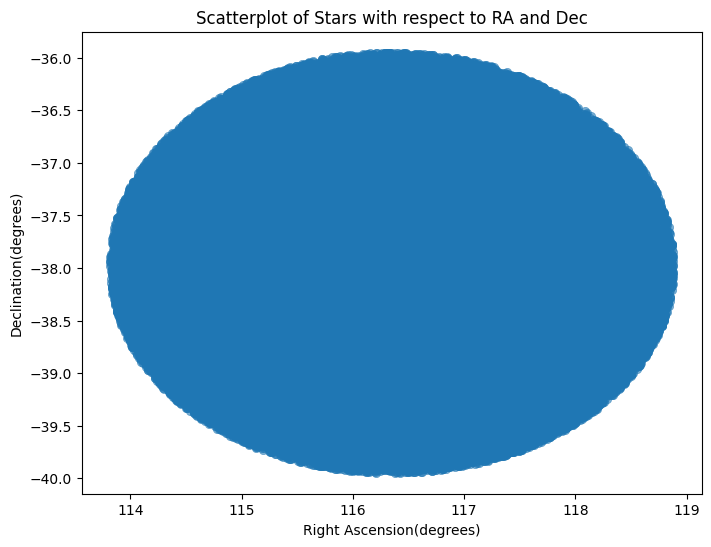

<Figure size 1000x600 with 0 Axes>

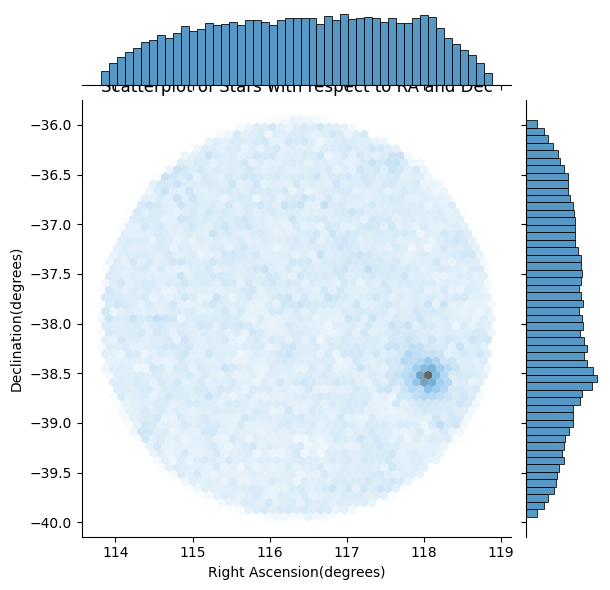

<Figure size 1000x600 with 0 Axes>

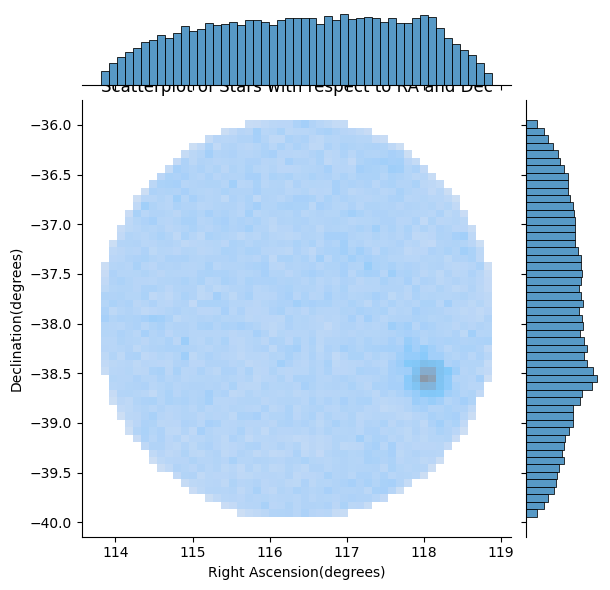

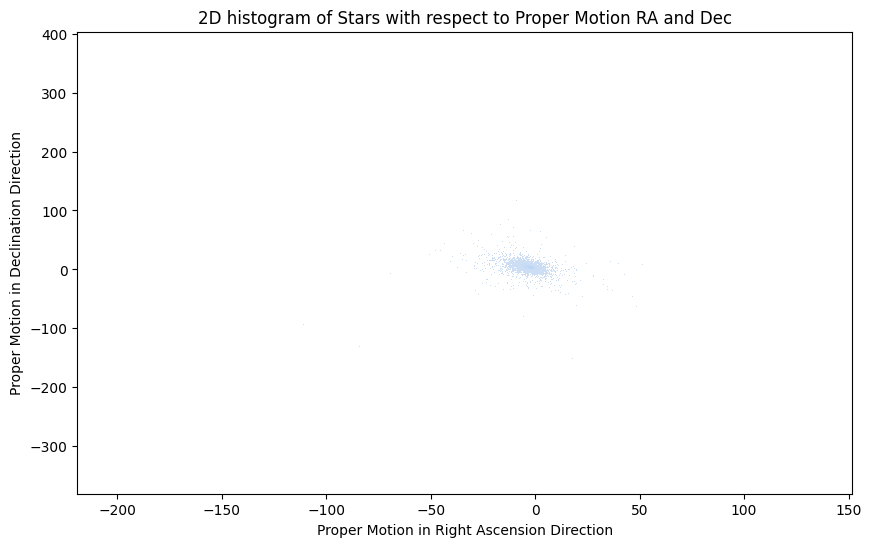

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  cset = contour_func(


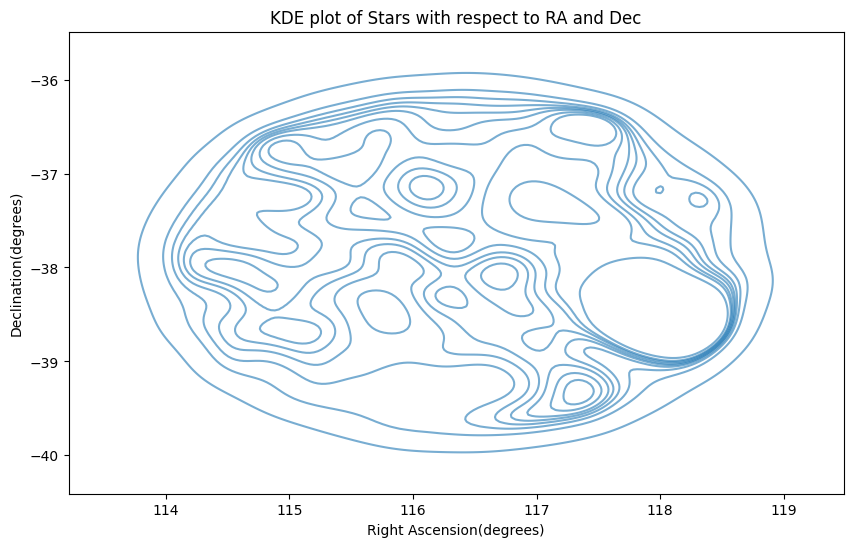

In [ ]:
import seaborn as sns

plt.figure(figsize = (8,6))
sns.scatterplot(x = clean2DF['ra'], y = clean2DF['dec'], alpha = 0.6, edgecolor = None)
plt.title("Scatterplot of Stars with respect to RA and Dec")
plt.xlabel("Right Ascension(degrees)")
plt.ylabel("Declination(degrees)")
plt.show()

# This creates a scatter plot with the variables 'ra' (Right Ascension) on the x-axis and 'dec' (Declination) on the y-axis.

plt.figure(figsize = (10,6))
sns.jointplot(x = clean2DF['ra'], y = clean2DF['dec'], alpha = 0.6, edgecolor = None, kind = 'hex')
plt.title("Scatterplot of Stars with respect to RA and Dec")
plt.xlabel("Right Ascension(degrees)")
plt.ylabel("Declination(degrees)")
plt.show()

# This creates a hexagonal binning plot using the jointplot function of seaborn with Right ascension on the x-axis and Declination on y-axis.
# This is a way to manage overplotting in scatter plots where two-dimensional bins are used instead of points.

plt.figure(figsize = (10,6))
sns.jointplot(x = clean2DF['ra'], y = clean2DF['dec'], alpha = 0.6, edgecolor = None, kind = 'hist')
plt.title("Scatterplot of Stars with respect to RA and Dec")
plt.xlabel("Right Ascension(degrees)")
plt.ylabel("Declination(degrees)")
plt.show()

# This creates a two-dimensional histogram plot using the joint plot function of Seaborn with Right ascension on the x-axis and Declination on y-axis.

plt.figure(figsize = (10,6))
sns.histplot(x = clean2DF['pmra'], y = clean2DF['pmdec'], alpha = 0.6, edgecolor = None)
plt.title("2D histogram of Stars with respect to Proper Motion RA and Dec")
plt.xlabel("Proper Motion in Right Ascension Direction")
plt.ylabel("Proper Motion in Declination Direction")
plt.show()

# This creates a 2D histogram of the proper motion in Right Ascension ('pmra') and Declination ('pmdec') directions using the histplot function of Seaborn.

plt.figure(figsize = (10,6))
sns.kdeplot(x = clean2DF['ra'], y = clean2DF['dec'], alpha = 0.6, edgecolor = None)
plt.title("KDE plot of Stars with respect to RA and Dec")
plt.xlabel("Right Ascension(degrees)")
plt.ylabel("Declination(degrees)")
plt.show()

# This creates a Kernel Density Estimate (KDE) plot that estimates the probability density function of the random variables 'ra' and 'dec'.
# The KDE is a way to visualize the distribution of observations in a dataset, analogous to a histogram. The sns.kdeplot function is used for this plot.


There is one cluster that should become obvious in the plots showing R.A. vs decl. ([NGC2477](https://en.wikipedia.org/wiki/NGC_2477)). Manually isolate the stars in this cluster by selecting stars in the approprate R.A. and decl. range, and explore its properties by plotting the stars separately onto the entire distribution (e.g., plots showing the the distances, the proper motions etc.)

<font color='blue'> **(1d)** Choose three plots that best highlight the properties of NGC2477 and include them in your submitted document. Be sure to include associated captions. </font>

(2425, 28)


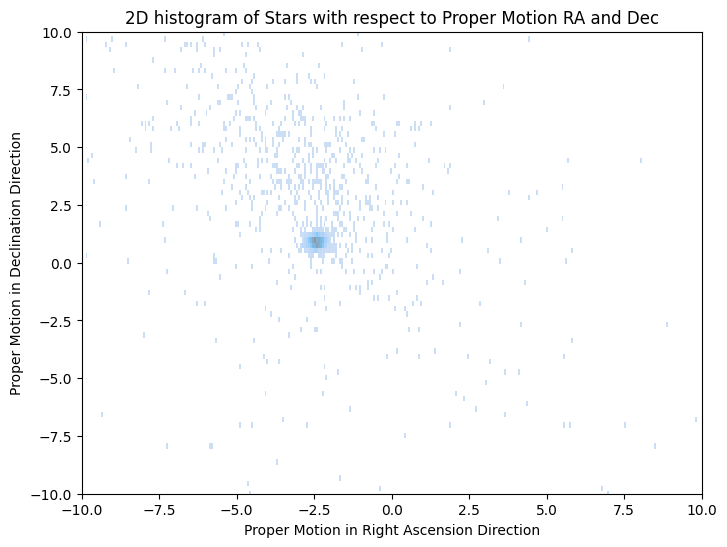

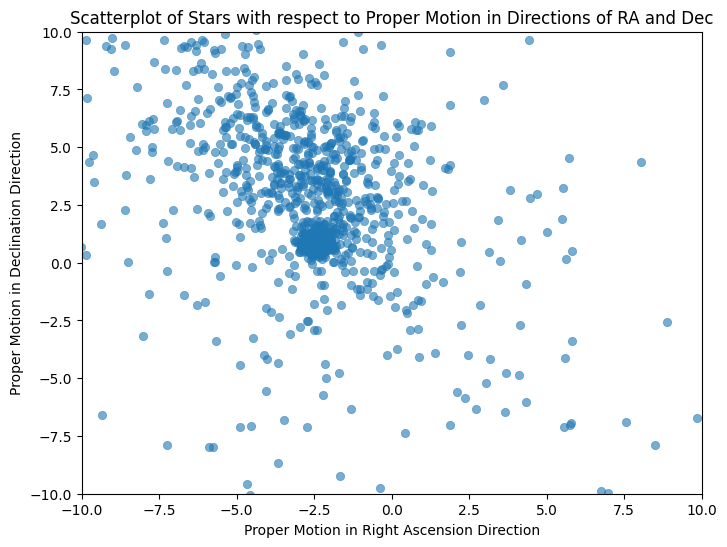

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  cset = contour_func(


<Figure size 800x600 with 0 Axes>

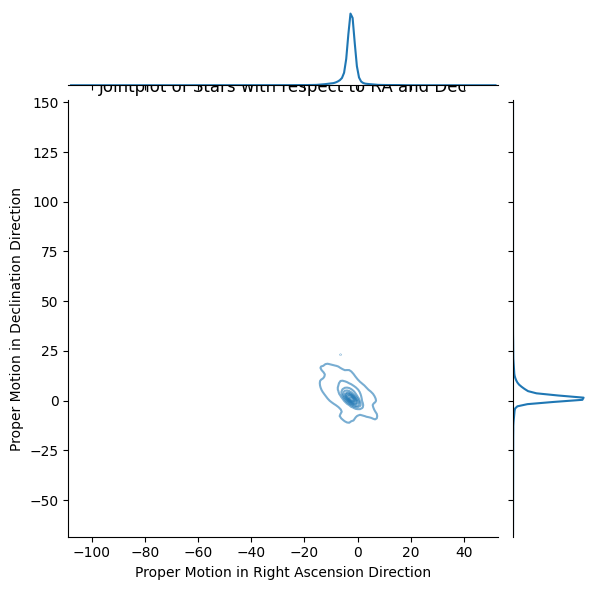

<Figure size 1000x800 with 0 Axes>

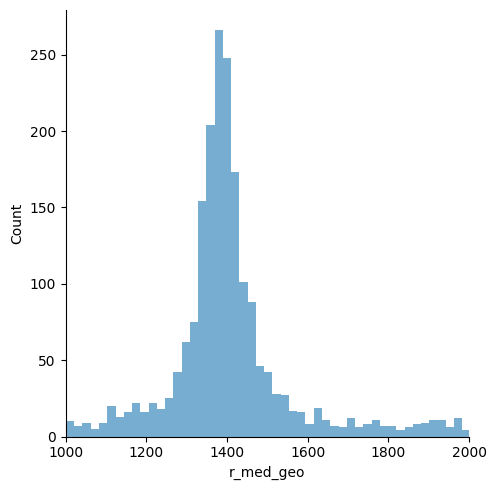

<Figure size 1000x800 with 0 Axes>

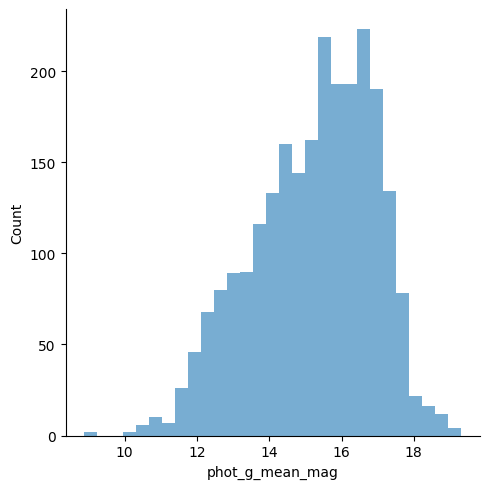

<Figure size 1000x800 with 0 Axes>

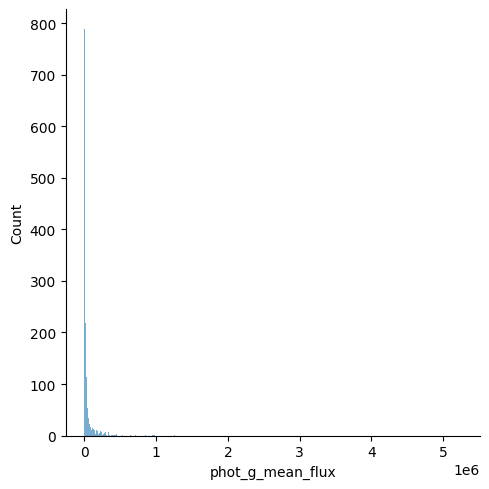

In [ ]:
clean3DF = clean2DF[(clean2DF['dec'] < -38.4) & (clean2DF['dec'] > -38.8) & (clean2DF['ra'] > 117.8) & (clean2DF['ra'] < 118.3)]

# From the plots above, we could clearly see the cluster NGC2477 so we define a new dataframe 'clean3DF' where we manually isolate the stars in this cluster by defining the
# appropriate R.A. and Declination range in order to explore its properties.

print(clean3DF.shape) # This is just to see the size of the new dataframe and acts as a proof of us having successfuly isolated the NGC2477 cluster.

plt.figure(figsize = (8,6))
sns.histplot(x = clean3DF['pmra'], y = clean3DF['pmdec'], alpha = 0.6, edgecolor = None)
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.title("2D histogram of Stars with respect to Proper Motion RA and Dec")
plt.xlabel("Proper Motion in Right Ascension Direction")
plt.ylabel("Proper Motion in Declination Direction")
plt.show()

# This generates a 2D histogram for the proper motion of stars in Right Ascension (pmra) and Declination (pmdec), which are indicators of how stars move across the sky.

plt.figure(figsize = (8,6))
sns.scatterplot(x = clean3DF['pmra'], y = clean3DF['pmdec'], alpha = 0.6, edgecolor = None)
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.title("Scatterplot of Stars with respect to Proper Motion in Directions of RA and Dec")
plt.xlabel("Proper Motion in Right Ascension Direction")
plt.ylabel("Proper Motion in Declination Direction")
plt.show()

# Here, a scatter plot for the same variables (pmra and pmdec) is created, allowing one to see the individual data points

plt.figure(figsize = (8,6))
sns.jointplot(x = clean3DF['pmra'], y = clean3DF['pmdec'], alpha = 0.6, edgecolor = None, kind = 'kde')
plt.title("Jointplot of Stars with respect to RA and Dec")
plt.xlabel("Proper Motion in Right Ascension Direction")
plt.ylabel("Proper Motion in Declination Direction")
plt.show()

# This creates a Kernel Density Estimate (KDE) plot which shows the density distribution of stars in the Proper Motion in Right Ascension and Declination space.

plt.figure(figsize = (10,8))
sns.displot(x = clean3DF['r_med_geo'], alpha = 0.6, edgecolor = None)
plt.xlim(1000,2000) # sets the limits of the x-axis to display the range from 1000 to 2000.
plt.show()

# This creates a distribution plot for the r_med_geo which is the median geometric estimate of the distance to the source.

plt.figure(figsize = (10,8))
sns.displot(x = clean3DF['phot_g_mean_mag'], alpha = 0.6, edgecolor = None)
plt.show()

# This creates a univariate distribution plot for the photometric mean magnitude (phot_g_mean_mag), which represents the average brightness of stars as observed in the
# 'g' (green) band of the optical spectrum.

plt.figure(figsize = (10,8))
sns.displot(x = clean3DF['phot_g_mean_flux'], alpha = 0.6, edgecolor = None)
plt.show()

# This produces a distribution plot for the photometric mean flux (phot_g_mean_flux), a measure of the total light received from a star in the same 'g' band.



# <font color=red>You should aim to get to here by the end of the first week of this lab!</font>

# Part 2: Running GMM

In this part, you will begin using Gaussian Mixture Modelling to try to detect clusters, and to identify which stars in the dataset are most likely to belong to those clusters.


## 2.1 Initial Experimentation with GMM

In the above exploratory phase, the NGC2477 cluster was visible as a localised region with a high number density of stars. In the Week 8 Lectorial, we will learn about how the [scikit learn Gaussian Mixture Models](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) (see also [here](https://scikit-learn.org/stable/modules/mixture.html#gmm))  can be used to partition data into a number of different components, and then predict which data points belong to the different components.

Using your analysis above to guide you, create a dataframe that contains stars in the *distance range* that encompasses the NGC2477 cluster (**only select based on distance (r_med_geo) at this stage**). This dataset will be used to get a handle on how the GMM process works before moving to finding other clusters in the whole sample in Part 2.2. Perform the following tasks on your new NGC2477 dataset:

### Step 1:
Start by running GMM on only the R.A. and decl., using 2 components (that is, use two gaussian components to fit the data). Explore the outputs: examine the "means_", "covariances_", and use the "predict" method to assign membership of stars to the 2 components.

<font color='blue'> **(2a)** Plot your results as a scatterplot, using different colours to highlight stars belonging to the different components. Do the results make sense? Do you need more components?</font>

In [ ]:
clean4DF = clean2DF[(clean2DF['r_med_geo'] < 1500) & (clean2DF['r_med_geo'] > 1200)]

# clean4DF is the name of our new datafram with 'r_med_geo' set within a distance range that encompasses the NGC2477 cluster.
# This distance range was chosen based on the Histogram plot of the distribution of stars with respect to r_med_geo which gave us a Gaussian Distribution and the median distance
# covered by that Gaussian is what we decided as the range of r_med_geo to be.

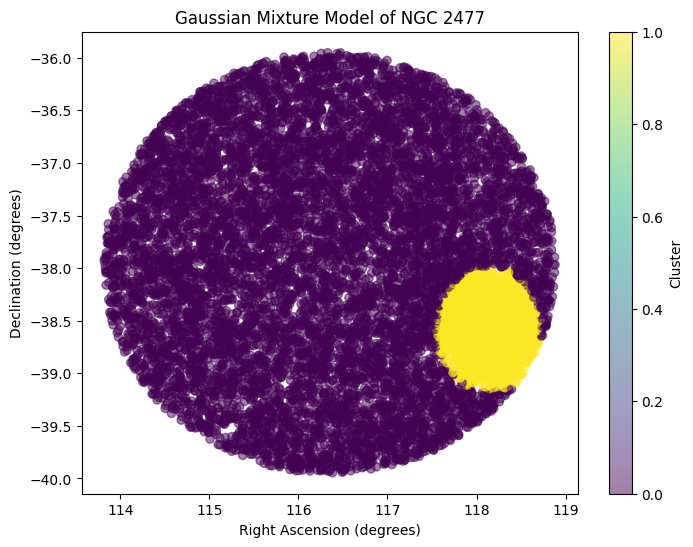

Means: [[116.28502214 -37.92403832]
 [118.07283138 -38.54375579]]
Covariances:
 [[[ 1.49783699e+00  1.47412260e-02]
  [ 1.47412260e-02  1.03305881e+00]]

 [[ 5.17598961e-02 -8.87462900e-04]
  [-8.87462900e-04  5.23856680e-02]]]
[0 0 0 ... 0 0 0]


In [ ]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Selecting the data for GMM
X = clean4DF[['ra', 'dec']]

# This line selects the relevant columns from your DataFrame 'clean4DF', specifically the right ascension (ra), declination (dec).
# This forms the dataset 'X' that will be used in the GMM.

# Creating the Gaussian Mixture Model with two components
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
gmm.fit(X)

# Initializes a GMM with 2 components, using the 'full' covariance type which allows each component to have its own general covariance matrix, enhancing the model's flexibility.
# Fits the GMM to the data 'X'.

# Predict the clusters
labels = gmm.predict(X)

# This line uses the fitted model to predict the cluster for each data point in 'X'.

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X['ra'], X['dec'], c=labels, cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster')
plt.title('Gaussian Mixture Model of NGC 2477')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.show()

# Output the means and covariances of the clusters
print("Means:", gmm.means_)
print("Covariances:\n", gmm.covariances_)
print(labels)

In [ ]:
# Diagonal elements of the covariance matrix represent the variance of each variable (RA, Dec). These values show how much each variable varies on its own within the cluster.
# From the result above, the covariance matrix 2 represents our cluster.

### Step 2:
Repeat Step 1, but now include R.A., decl., pmRA , and pmdec in the fit. <font color='blue'> **(2b)** How does the result compare to that in step 1? </font>

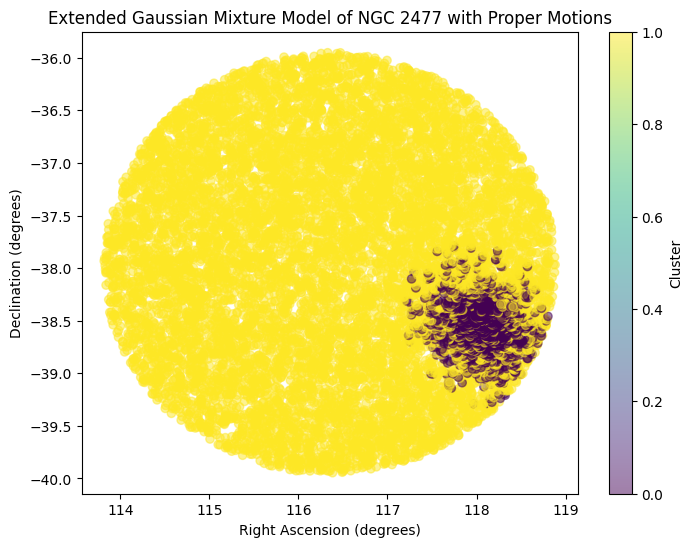

Extended Means: [[118.04486233 -38.53868143  -2.42474155   0.90426008]
 [116.37573137 -37.9544717   -2.77477647   3.89924755]]
Extended Covariances:
 [[[ 4.73525942e-02 -6.21773320e-03 -1.45434223e-04 -2.23892457e-03]
  [-6.21773320e-03  3.50149778e-02  5.61080147e-05 -5.12396166e-05]
  [-1.45434223e-04  5.61080147e-05  2.98026168e-02  1.79682151e-03]
  [-2.23892457e-03 -5.12396166e-05  1.79682151e-03  3.23004845e-02]]

 [[ 1.59507011e+00 -4.02383795e-02 -2.65328635e-01  1.17976788e-02]
  [-4.02383795e-02  1.00906493e+00  2.68622359e-02 -1.52542690e-01]
  [-2.65328635e-01  2.68622359e-02  1.26102524e+01 -7.64224859e+00]
  [ 1.17976788e-02 -1.52542690e-01 -7.64224859e+00  2.37100434e+01]]]


In [ ]:
# Selecting the extended data for GMM, including proper motions
X_2 = clean4DF[['ra', 'dec', 'pmra', 'pmdec']]

# This line selects the relevant columns from our DataFrame 'clean4DF', specifically the right ascension (ra), declination (dec), proper motion in right ascension (pmra),
# and proper motion in declination (pmdec). This forms the dataset X_2 that will be used in the GMM.

# Creating the Gaussian Mixture Model with two components
gmm_2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
gmm_2.fit(X_2)

# Initializes a GMM with 2 components, using the 'full' covariance type which allows each component to have its own general covariance matrix, enhancing the model's flexibility.
# Fits the GMM to the data 'X_2'.

# Predict the clusters
labels_2 = gmm_2.predict(X_2)

 # This line uses the fitted model to predict the cluster for each data point in 'X_2'.

# Plotting results, though visualizing 4D data in a 2D plot is challenging, we visualize RA and Dec only here
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2['ra'], X_2['dec'], c=labels_2, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Cluster')
plt.title('Extended Gaussian Mixture Model of NGC 2477 with Proper Motions')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.show()

# Output the extended means and covariances of the clusters
print("Extended Means:", gmm_2.means_)
print("Extended Covariances:\n", gmm_2.covariances_)

In [ ]:
# Diagonal elements of the covariance matrix represent the variance of each variable (RA, Dec, pmra, pmdec).
# These values show how much each variable varies on its own within the cluster. From the result above, the covariance matrix 1 represents our cluster.

### Step 3:
Here, we want to determine how many components are required to fit the data without "overfitting". Repeat step 2, but code up a loop that increases the number of components fitted by GMM. Determine the "Bayesian Information Criteria", or [BIC](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture.bic) (discussed in [Week 3 lectorial](https://github.com/MQ-ASTR3110/ASTR3110_Tutorial_Notebooks_2024/blob/master/Solution_Notebooks/ASTR3110_Tutorial_3_Fitting.ipynb) and [here](https://en.wikipedia.org/wiki/Bayesian_information_criterion)) for each different fit. Report the results by printing to screen. We can use the BIC to determine the optimal number of components that are required to improve the fit without overfitting. This is done by ensuring that in going from a smaller to larger number of components the BIC decreases by at least 6. As your code loops through the number of components be sure to save the corresponding BIC values.

<font color='blue'> **(2c)** Plot the the BIC value as a function of the number of components. Also plot the *change* in BIC as the number of components is increased. Use this plot to determine the optimum number of components, i.e., find the component number where if you increase that number by one, the change in the BIC no longer *decreases* by more than 6.</font>

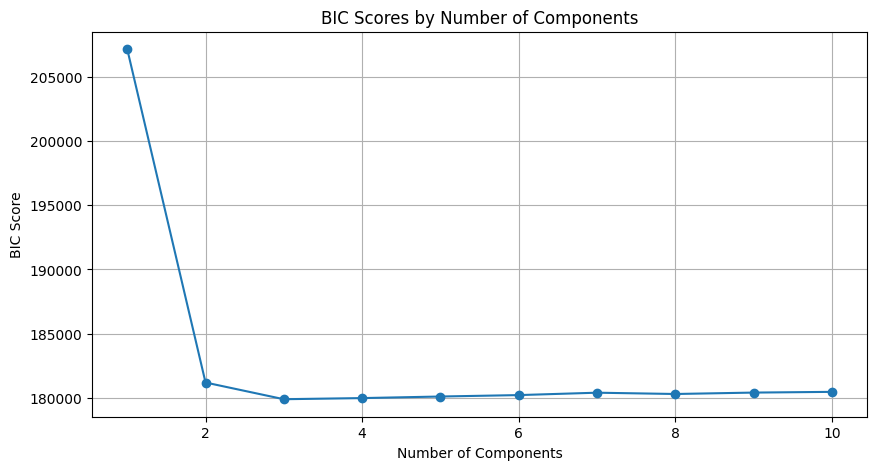

BIC Differences: [-25907.82602988  -1297.82452929     88.22254589    122.09503719
    110.77149151    186.05099102   -100.9986467     109.63794409
     56.39570848]


In [ ]:
# 'clean4DF' is our DataFrame with the stars in the NGC 2477 distance range
X_3 = clean4DF[['ra', 'dec', 'pmra', 'pmdec']]

# This selects the right ascension, declination, proper motion in right ascension, and proper motion in declination from our dataframe 'clean4DF',
# creating a new Dataset 'X_3' that will be used for the GMM.

# List to hold the BIC values
bics = []
n_components_range = range(1, 11)

for n_components in n_components_range: # Loops through each number of components specified in n_components_range.
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    # For each number, it initializes a GMM with that many components, using a 'full' covariance structure for flexibility and setting a random state for reproducibility.
    gmm.fit(X_3) # Fits the model to the data X_3
    bics.append(gmm.bic(X_3)) # Appends the BIC value obtained with the model to the bics list.



# Plotting BIC values
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bics, marker='o')
plt.title('BIC Scores by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.grid(True)
plt.show()

# Finding the optimal number of components
bic_differences = np.diff(bics) # Calculates the difference between each BIC value to see how much the BIC decreases when adding another component.
print("BIC Differences:", bic_differences)

In [ ]:
# From the plot and the vaues of the BIC Differences, we can see that the component number where if you increase that number by one,
# the change in the BIC no longer decreases by more than 6 is 3. So, our optimum number of components is 3.

### Step 4:
Repeat the GMM fit using the optimum number of components determined in Step 3.

<font color='blue'> **(2d)** Produce scatterplots showing the spatial and proper-motion distributions, again using different colours to highlight stars belonging to the different components as was done in (2a).</font>
    
<font color='blue'> **(2e)** Determine the the mean positions of the components in (R.A., decl.) and (pmRA, pmDec), as well as the corresponding dispersion. The dispersion can be determined by examining the square root of the diagonal terms in the covariance matrix for each component. Compare the results for the different components. Which component is associated with NGC2477? Explain your interpretation.</font>


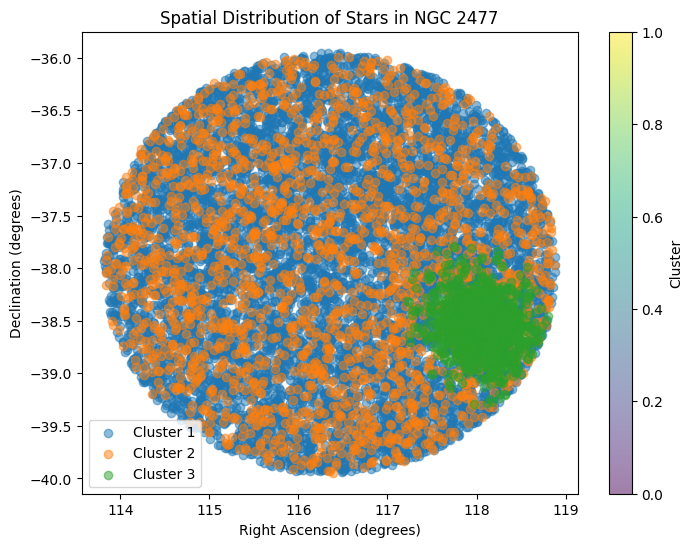

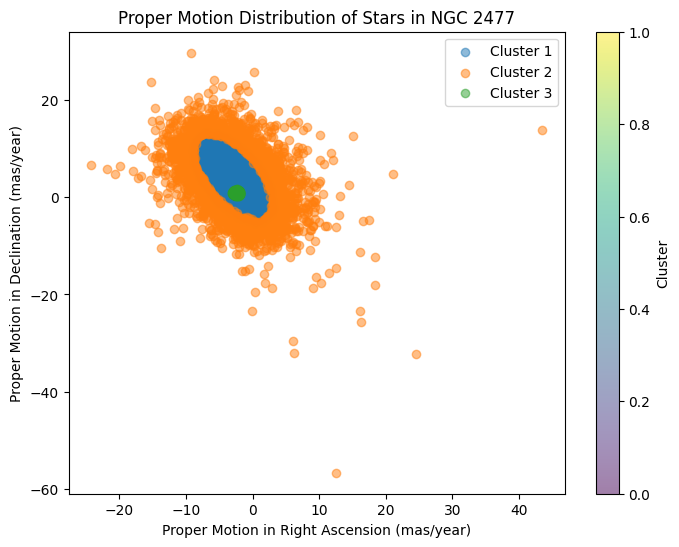

Cluster 1 Mean RA, Dec: (116.38907022380467, -37.940844265630936)
Cluster 1 Mean pmRA, pmDec: (-2.8526817105598834, 3.9672959163314685)
Cluster 1 Dispersion (sqrt of covariance diagonal): RA: 1.2584829804638364, Dec: 1.007388640752247, pmRA: 2.523527143059504, pmDec: 3.6971328281329057

Cluster 2 Mean RA, Dec: (116.35393501854386, -37.981629271549465)
Cluster 2 Mean pmRA, pmDec: (-2.6250103542105068, 3.7622246346872306)
Cluster 2 Dispersion (sqrt of covariance diagonal): RA: 1.2719910892029143, Dec: 0.9977944429370653, pmRA: 4.945912292320235, pmDec: 6.543278024113902

Cluster 3 Mean RA, Dec: (118.04540022760565, -38.539088978385045)
Cluster 3 Mean pmRA, pmDec: (-2.425079596366791, 0.9041618297409569)
Cluster 3 Dispersion (sqrt of covariance diagonal): RA: 0.2164507694813075, Dec: 0.18521521348224365, pmRA: 0.1717689108806059, pmDec: 0.1790779088889356



In [ ]:
# 'clean4DF' is our DataFrame with stars in the NGC 2477 distance range
X_4 = clean4DF[['ra', 'dec', 'pmra', 'pmdec']]

# This line selects the relevant columns from our DataFrame 'clean4DF', specifically the right ascension (ra), declination (dec), proper motion in right ascension (pmra),
# and proper motion in declination (pmdec). This forms the dataset 'X_4' that will be used in the GMM.

# Create the Gaussian Mixture Model with 3 components
gmm_4 = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
gmm_4.fit(X_4) # Fits the GMM to the data 'X_4'.

# Initializes a GMM with 3 components, using the 'full' covariance type which allows each component to have its own general covariance matrix, enhancing the model's flexibility

# Predict the clusters
labels_4 = gmm_4.predict(X_4)

# This line uses the fitted model to predict the cluster label for each data point in 'X_4'.

# Plotting spatial distribution
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.scatter(X_4['ra'][labels_4 == i], X_4['dec'][labels_4 == i], alpha=0.5, label=f'Cluster {i+1}')
# # Loops through each cluster to plot the ra and dec of stars belonging to each cluster, using different colors automatically handled by matplotlib.
plt.colorbar(label='Cluster')
plt.title('Spatial Distribution of Stars in NGC 2477')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.legend()
plt.show()

# Plotting proper motion distribution
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.scatter(X_4['pmra'][labels_4 == i], X_4['pmdec'][labels_4 == i], alpha=0.5, label=f'Cluster {i+1}')
# Similar to the spatial distribution, but plots pmra and pmdec to show how stars in each cluster move.
plt.colorbar(label='Cluster')
plt.title('Proper Motion Distribution of Stars in NGC 2477')
plt.xlabel('Proper Motion in Right Ascension (mas/year)')
plt.ylabel('Proper Motion in Declination (mas/year)')
plt.legend()
plt.show()

# Print mean positions and dispersions
means = gmm_4.means_
covariances = gmm_4.covariances_
for i in range(3):
    print(f"Cluster {i+1} Mean RA, Dec: ({means[i][0]}, {means[i][1]})")
    print(f"Cluster {i+1} Mean pmRA, pmDec: ({means[i][2]}, {means[i][3]})")
    print(f"Cluster {i+1} Dispersion (sqrt of covariance diagonal): RA: {np.sqrt(covariances[i][0, 0])}, Dec: {np.sqrt(covariances[i][1, 1])}, pmRA: {np.sqrt(covariances[i][2, 2])}, pmDec: {np.sqrt(covariances[i][3, 3])}")
    print()

# Retrieves and prints the means and standard deviations (sqrt of covariance diagonal terms) for each cluster in both spatial and proper motion dimensions,
# providing insights into the location and spread of each cluster.

## 2.2 Finding the other clusters <font color=red>(you should aim to have made a good start at this part by the end of week 2 of this lab!)</font>

Now that you have used GMM to identify NGC2477, as well as determine which stars are most likely members, you can find the other two clusters in the data (NGC2451A and NGC2451B). These two clusters are not at all obvious as overdensities in R.A. and decl. because they are lost in the background of field stars. We can find these clusters in a semi-automated fashion by running GMM as outlined above, but now in separate distance bins, and looking for compact clusterings in proper motion similar to those that we identified for NGC2477. The segregation by distance helps to increase the contrast of the cluster stars against the backdrop of the field stars, which in turn allows GMM to more easily locate the star clusters in RA, dec, pmRA and pmdec.

To do this, you will need design an algorithm that does the following:
- Generate bins in distance, e.g., 8 distance bins with width 250pc so that the first bin runs from 0-250pc, the second 250-500pc, and so forth.
- For each distance bin select the subset of stars within that distance range.
- On the subset of stars, run your GMM algorithm on RA, dec, pmra, pmdec, using the BIC to determine the optimal number of components required (the optimum number will likely be different for each distance range).
- Generate appropriate plots and print any results/outputs that will help you to understand which distance ranges contain clusters, and what their properties are.


In [ ]:
# For this part, we'll switch back to using the dataframe clean2DF because now our goal is to find the other 2 clusters across the entire range of 'r_med_geo'

<ipython-input-25-e93f5f5cb954>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean2DF['distance_bin'] = pd.cut(clean2DF['r_med_geo'], bins=distance_bins, labels=distance_labels, include_lowest=True)


Bin 0, Cluster 1:
Mean RA, Dec: [116.37228234 -37.94171569]
Mean pmRA, pmDec: [-9.99005118  8.43970387]
Dispersion RA, Dec: [1.275722   0.99322258]
Dispersion pmRA, pmDec: [19.47951575 27.60781412]
Bin 0, Cluster 2:
Mean RA, Dec: [116.52391598 -37.90979327]
Mean pmRA, pmDec: [-13.55643685  -9.15261893]
Dispersion RA, Dec: [1.27450995 0.94934778]
Dispersion pmRA, pmDec: [57.4088211  86.40603094]
Bin 0, Cluster 3:
Mean RA, Dec: [115.84653232 -38.11736191]
Mean pmRA, pmDec: [-21.03488539  15.28455173]
Dispersion RA, Dec: [0.88194206 0.81395037]
Dispersion pmRA, pmDec: [0.75408537 0.6506347 ]


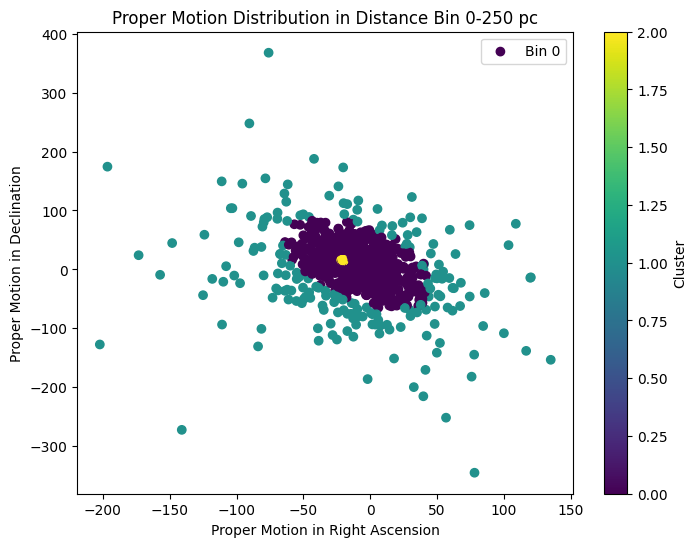

Bin 1, Cluster 1:
Mean RA, Dec: [116.32678217 -37.93550851]
Mean pmRA, pmDec: [-8.95654253 10.09060078]
Dispersion RA, Dec: [1.25575395 1.00527481]
Dispersion pmRA, pmDec: [ 8.2330348 11.60689  ]
Bin 1, Cluster 2:
Mean RA, Dec: [116.29235144 -37.99984552]
Mean pmRA, pmDec: [-4.21889511  3.86289831]
Dispersion RA, Dec: [1.24873    1.00380699]
Dispersion pmRA, pmDec: [22.06868004 30.75914924]
Bin 1, Cluster 3:
Mean RA, Dec: [116.16088632 -37.94875255]
Mean pmRA, pmDec: [-9.3628131   4.72047823]
Dispersion RA, Dec: [0.89786873 0.83876872]
Dispersion pmRA, pmDec: [0.95456032 0.37632833]
Bin 1, Cluster 4:
Mean RA, Dec: [116.33974014 -37.90691354]
Mean pmRA, pmDec: [-1.97561811 -0.04373152]
Dispersion RA, Dec: [1.258131   1.01024088]
Dispersion pmRA, pmDec: [ 8.83032106 13.25538686]


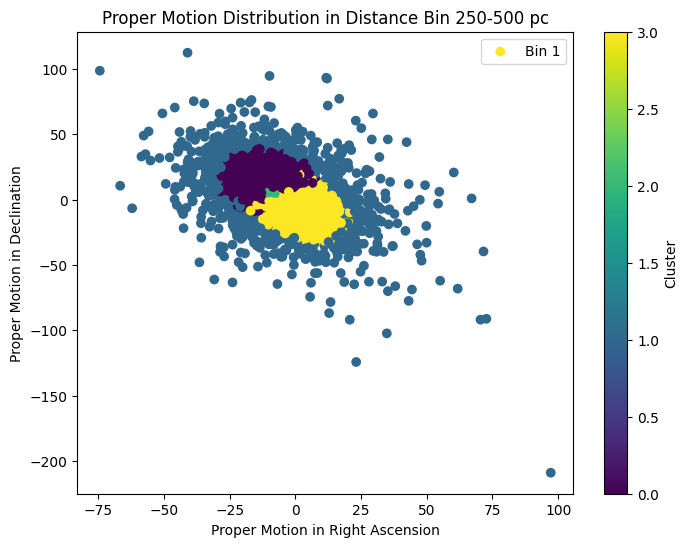

Bin 2, Cluster 1:
Mean RA, Dec: [116.30090538 -37.94964541]
Mean pmRA, pmDec: [-1.44247737 -1.28342391]
Dispersion RA, Dec: [1.28722395 1.00050747]
Dispersion pmRA, pmDec: [6.59886416 8.09889939]
Bin 2, Cluster 2:
Mean RA, Dec: [116.45073927 -37.89681978]
Mean pmRA, pmDec: [-4.65230313  6.50788699]
Dispersion RA, Dec: [1.26210302 1.00913853]
Dispersion pmRA, pmDec: [3.61102639 5.70396355]
Bin 2, Cluster 3:
Mean RA, Dec: [116.30789363 -37.96171059]
Mean pmRA, pmDec: [-9.97594663 13.78156147]
Dispersion RA, Dec: [1.24274569 1.02498577]
Dispersion pmRA, pmDec: [7.07525896 9.03260975]
Bin 2, Cluster 4:
Mean RA, Dec: [116.28237446 -37.98956609]
Mean pmRA, pmDec: [-1.00946458  0.47586816]
Dispersion RA, Dec: [1.27330485 1.03503097]
Dispersion pmRA, pmDec: [16.03756439 19.12089365]


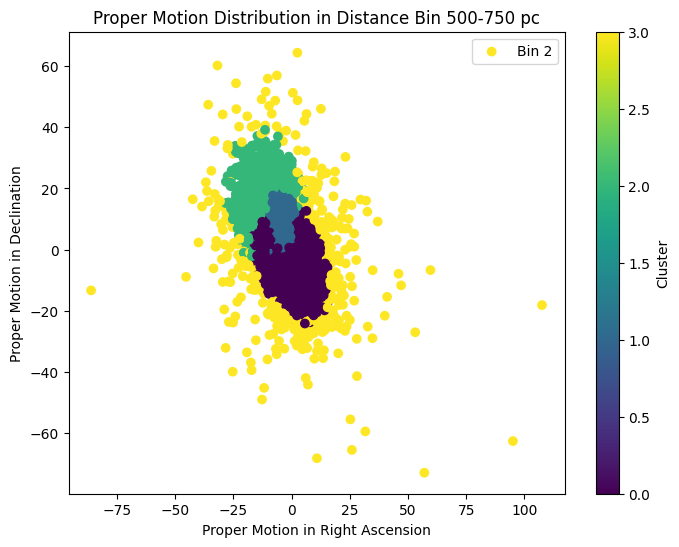

Bin 3, Cluster 1:
Mean RA, Dec: [116.38942103 -37.9567403 ]
Mean pmRA, pmDec: [-3.62228018  4.43941319]
Dispersion RA, Dec: [1.27348322 1.01041672]
Dispersion pmRA, pmDec: [3.7194428  5.33125948]
Bin 3, Cluster 2:
Mean RA, Dec: [116.29159341 -37.9409709 ]
Mean pmRA, pmDec: [-2.50919822  3.04936773]
Dispersion RA, Dec: [1.27451914 1.00870618]
Dispersion pmRA, pmDec: [ 8.5562379  11.33015878]


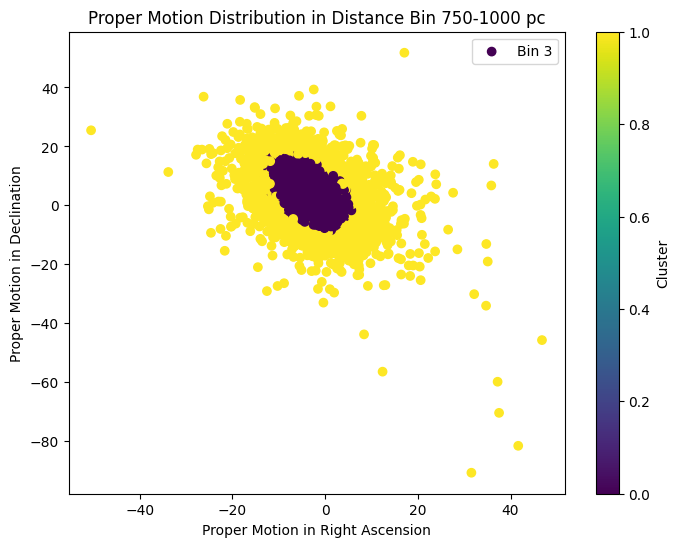

Bin 4, Cluster 1:
Mean RA, Dec: [116.44571904 -37.97360543]
Mean pmRA, pmDec: [-3.18654885  4.16632898]
Dispersion RA, Dec: [1.26239753 0.99930464]
Dispersion pmRA, pmDec: [2.97050867 4.24371759]
Bin 4, Cluster 2:
Mean RA, Dec: [116.32318974 -37.96118376]
Mean pmRA, pmDec: [-2.67998366  3.36524034]
Dispersion RA, Dec: [1.26302632 1.00489724]
Dispersion pmRA, pmDec: [5.92531245 7.91569445]


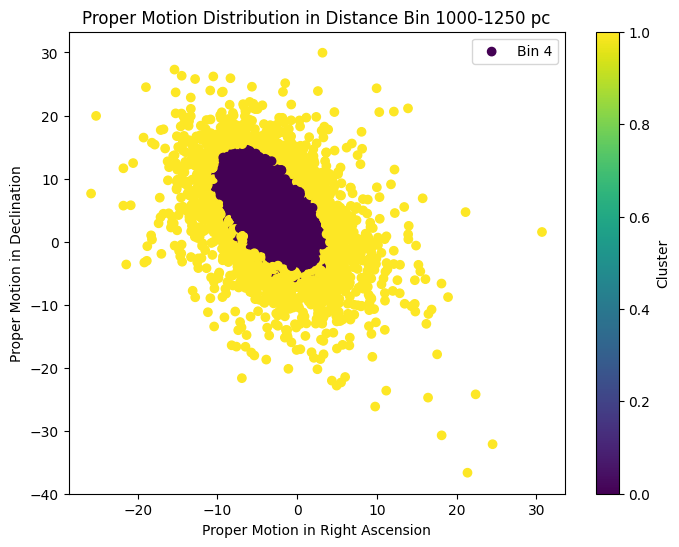

Bin 5, Cluster 1:
Mean RA, Dec: [116.3127353  -38.01079412]
Mean pmRA, pmDec: [-2.40578942  3.85220645]
Dispersion RA, Dec: [1.26575108 1.00360424]
Dispersion pmRA, pmDec: [2.98456184 4.46699739]
Bin 5, Cluster 2:
Mean RA, Dec: [116.38319655 -37.93445362]
Mean pmRA, pmDec: [-2.54414388  3.87412074]
Dispersion RA, Dec: [1.28046073 0.99788558]
Dispersion pmRA, pmDec: [5.51713557 7.01657044]
Bin 5, Cluster 3:
Mean RA, Dec: [118.04673559 -38.5400336 ]
Mean pmRA, pmDec: [-2.424271    0.90469486]
Dispersion RA, Dec: [0.21559454 0.18478352]
Dispersion pmRA, pmDec: [0.17214986 0.17924417]
Bin 5, Cluster 4:
Mean RA, Dec: [116.4625439  -37.89840203]
Mean pmRA, pmDec: [-3.20049852  3.87830388]
Dispersion RA, Dec: [1.25022453 1.00965223]
Dispersion pmRA, pmDec: [2.36410066 3.40999537]


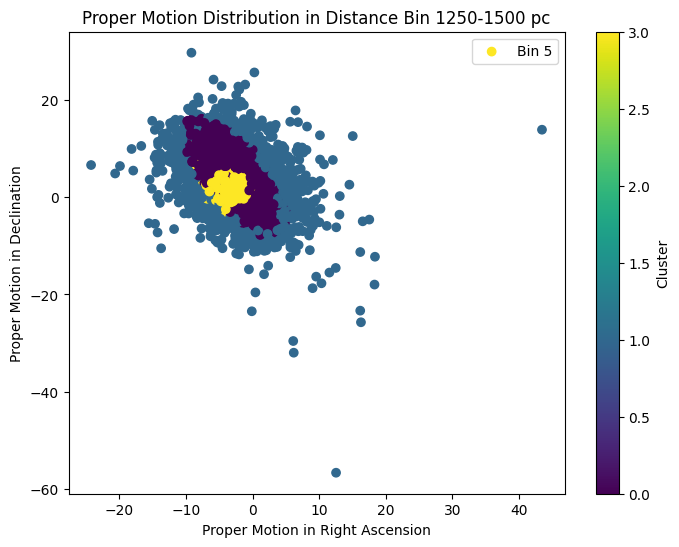

Bin 6, Cluster 1:
Mean RA, Dec: [116.07706395 -37.97084777]
Mean pmRA, pmDec: [-0.62375316  0.16114113]
Dispersion RA, Dec: [1.28235336 0.98529934]
Dispersion pmRA, pmDec: [3.4908105  4.02358256]
Bin 6, Cluster 2:
Mean RA, Dec: [116.19628795 -37.93713018]
Mean pmRA, pmDec: [-2.88410894  5.44614869]
Dispersion RA, Dec: [1.2812174  0.97691963]
Dispersion pmRA, pmDec: [2.12522619 2.02773571]
Bin 6, Cluster 3:
Mean RA, Dec: [116.39994418 -37.99981561]
Mean pmRA, pmDec: [-4.79811255  8.29464242]
Dispersion RA, Dec: [1.24969953 1.01721646]
Dispersion pmRA, pmDec: [3.27180024 3.39012974]
Bin 6, Cluster 4:
Mean RA, Dec: [116.65658635 -37.9194989 ]
Mean pmRA, pmDec: [-2.45494625  2.1547095 ]
Dispersion RA, Dec: [1.25089497 0.9830316 ]
Dispersion pmRA, pmDec: [1.81677274 2.12756423]


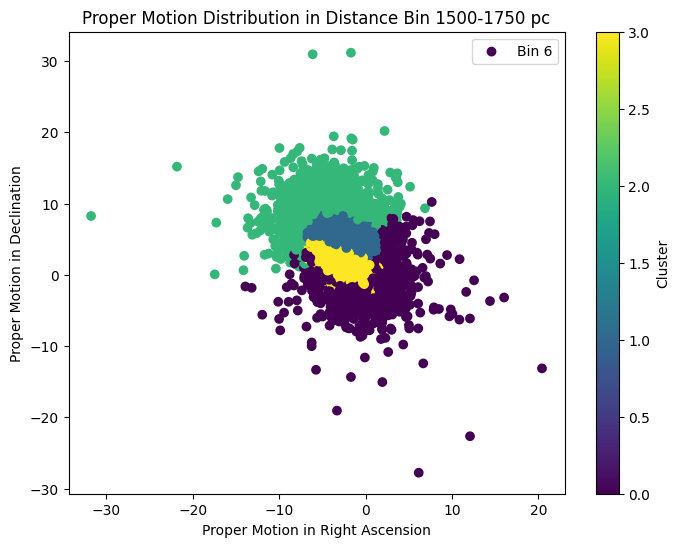

Bin 7, Cluster 1:
Mean RA, Dec: [116.4489643  -37.74013588]
Mean pmRA, pmDec: [-1.45029911  1.01764285]
Dispersion RA, Dec: [0.8736169  0.76307671]
Dispersion pmRA, pmDec: [1.91555027 2.89673497]
Bin 7, Cluster 2:
Mean RA, Dec: [116.0768274  -37.89040008]
Mean pmRA, pmDec: [-5.35451347  6.48604625]
Dispersion RA, Dec: [0.96239921 0.88021736]
Dispersion pmRA, pmDec: [1.76581575 1.68219696]
Bin 7, Cluster 3:
Mean RA, Dec: [116.36043126 -37.98478658]
Mean pmRA, pmDec: [-5.00141586  9.81652619]
Dispersion RA, Dec: [1.14493666 0.94377918]
Dispersion pmRA, pmDec: [2.02251839 1.38260027]
Bin 7, Cluster 4:
Mean RA, Dec: [115.26656775 -36.7781036 ]
Mean pmRA, pmDec: [-2.41732144  3.54851476]
Dispersion RA, Dec: [0.69610873 0.43764329]
Dispersion pmRA, pmDec: [2.03413003 3.20398009]
Bin 7, Cluster 5:
Mean RA, Dec: [114.97542678 -38.45222002]
Mean pmRA, pmDec: [-2.42650445  3.65496757]
Dispersion RA, Dec: [0.63667788 0.65051649]
Dispersion pmRA, pmDec: [2.04498608 3.06824251]
Bin 7, Cluster 6:
Me

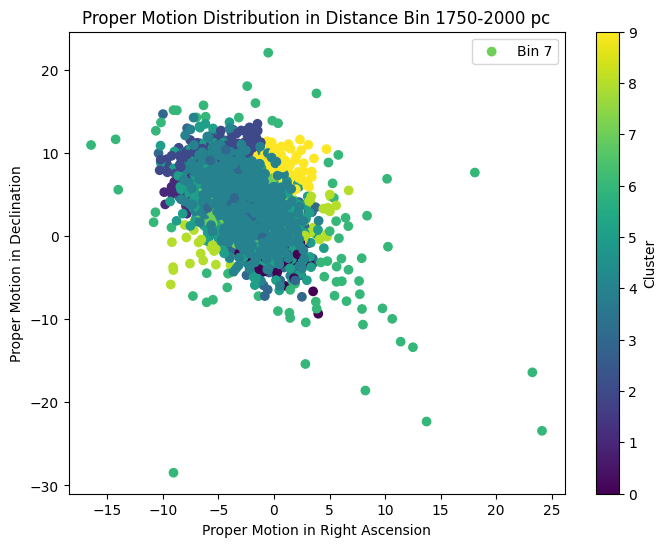

In [ ]:
# Define distance bins
distance_bins = np.arange(0, 2050, 250)
distance_labels = range(len(distance_bins) - 1)

# This creates an array starting from 0 up to (but not including) 2050, with steps of 250 pc. This results in eight bins.

# Categorize data into distance bins
clean2DF['distance_bin'] = pd.cut(clean2DF['r_med_geo'], bins=distance_bins, labels=distance_labels, include_lowest=True)

# pd.cut function is used to assign each star from clean2DF DataFrame into a distance bin based on its r_med_geo value.

# Store results
clusters_info = [] # Initializes an empty list to store information about the clusters found in each distance bin.

# Analyze each distance bin separately
for bin_label in distance_labels:
    subset = clean2DF[clean2DF['distance_bin'] == bin_label]
    if subset.empty:
        continue

# This loop iterates over each bin label, extracts the subset of stars that fall within that bin, and checks if the subset is empty. If yes, the loop continues to the next iteration.

    # Determine the range of components to test
    n_components_range = range(1, 11)  # General range for other bins
    if bin_label == 5 or bin_label == 6:
        n_components_range = [4]

# Adjusts the range of GMM components to test based on the bin. For bins 5 and 6, only 4 components are tested. For other bins, a range from 1 to 10 components is tested.

    bics = []
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
        gmm.fit(subset[['ra', 'dec', 'pmra', 'pmdec']])
        bics.append(gmm.bic(subset[['ra', 'dec', 'pmra', 'pmdec']]))

# These lines create and fit a Gaussian Mixture Model for each possible number of components.

    optimal_components = np.argmin(bics) + n_components_range[0]
    best_gmm = GaussianMixture(n_components=optimal_components, covariance_type='full', random_state=0)
    best_gmm.fit(subset[['ra', 'dec', 'pmra', 'pmdec']])
    labels = best_gmm.predict(subset[['ra', 'dec', 'pmra', 'pmdec']])

# For each number of components in the range, it fits a GMM and calculates the Bayesian Information Criterion to select the optimal number of components that minimizes the BIC.

    # Store or process your results
    clusters_info.append({
        'distance_bin': bin_label,
        'optimal_components': optimal_components,
        'means': best_gmm.means_,
        'covariances': best_gmm.covariances_,
        'labels': labels
    })

    # Appends the results including the bin label, optimal number of components, cluster means, covariances, and labels to the clusters_info list.

    # Print means and dispersions for each component
    for i in range(optimal_components):
        print(f"Bin {bin_label}, Cluster {i+1}:")
        print(f"Mean RA, Dec: {best_gmm.means_[i][:2]}")
        print(f"Mean pmRA, pmDec: {best_gmm.means_[i][2:]}")
        print(f"Dispersion RA, Dec: {np.sqrt(best_gmm.covariances_[i][:2, :2].diagonal())}")
        print(f"Dispersion pmRA, pmDec: {np.sqrt(best_gmm.covariances_[i][2:4, 2:4].diagonal())}")

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(subset['pmra'], subset['pmdec'], c=labels, cmap='viridis', label=f'Bin {bin_label}')
    plt.colorbar(scatter, label='Cluster')
    plt.title(f'Proper Motion Distribution in Distance Bin {bin_label*250}-{(bin_label+1)*250} pc')
    plt.xlabel('Proper Motion in Right Ascension')
    plt.ylabel('Proper Motion in Declination')
    plt.legend()
    plt.show()

    # Generates scatter plots for the proper motion distributions within each distance bin, color-coded by the identified clusters.
    # This visualizes how stars are grouped according to their proper motions, aiding in interpreting the clustering results.

<font color='blue'> **(2f)** Identify which of your distance bins contain clusters and explain why you think those bins contain clusters. Include plots that support your interpretation. </font>

## 2.3 Finalising the clusters and determining membership.

Use the results from the previous section to select appropriate distance ranges for the 3 clusters. Select the subset of stars within those distance ranges and rerun GMM on each subset in order to refine the membership. You should now only need to fit for 2 components; one for the cluster stars and one for the field stars. For this final part, you should include the distance (r_med_geo) in the GMM fit in order to get the best membership constraint for the stars.

You should now be able to decipher which stars do not belong to clusters (i.e., "field" stars") and which stars are members of the NGC2451A, NGC2451B or NGC2477 clusters.

<font color='blue'> **(2g)** Use your final membership to plot the distribution of clusters stars in position (R.A., dec), proper motion (pmRA, pmdec), and distance in comparision to non-cluster stars.</font>

<font color='blue'> **(2h)**  Use your final samples of member stars to determine the following parameters for each clusters: </font>
- <font color='blue'> The mean and dispersion of the distance, position, and proper motion.</font>
- <font color='blue'> The total number of member stars.  </font>

<font color='blue'>Compare/contrast these parameters for the three clusters.</font>

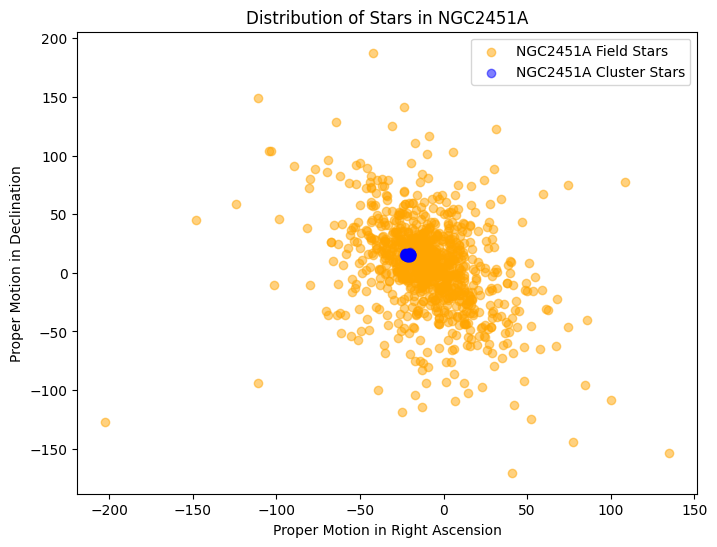

NGC2451A: Total number of member stars = 302
Component 1: Mean RA: 116.40972193521834, Dec: -37.94800698181866, pmRA: -9.860149640790391, pmDec: 5.948684768756335, r_med_geo: 192.94910708018452
Dispersion RA: 1.2802643657743524, Dec: 0.980987133715318, pmRA: 27.537947449898915, pmDec: 38.35127262241897, r_med_geo: 40.859475612606104
Component 2: Mean RA: 115.84416976898, Dec: -38.11708982140525, pmRA: -21.03740532708513, pmDec: 15.276079902207359, r_med_geo: 191.56218162084417
Dispersion RA: 0.8800854214859931, Dec: 0.8133138433139393, pmRA: 0.7536623585424782, pmDec: 0.6522683273089237, r_med_geo: 5.0028085212280775



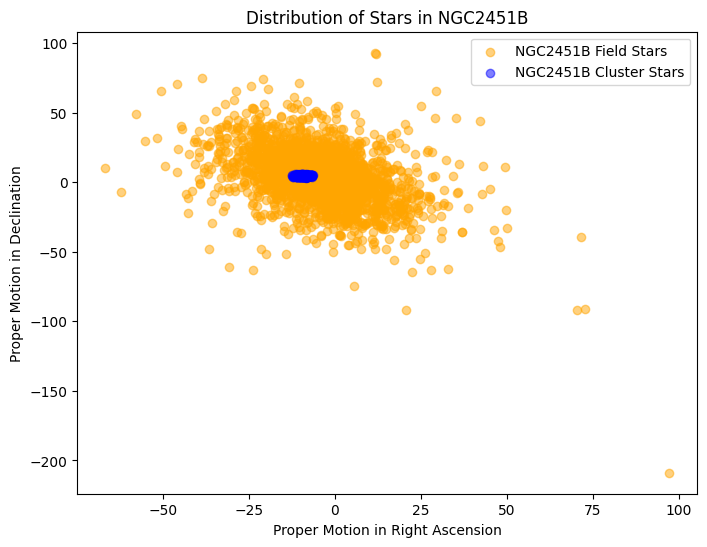

NGC2451B: Total number of member stars = 634
Component 1: Mean RA: 116.14568461482499, Dec: -37.95334324259026, pmRA: -9.423000026360867, pmDec: 4.713796735012243, r_med_geo: 370.68434415458546
Dispersion RA: 0.9054032870818048, Dec: 0.8172768489321274, pmRA: 0.9394221085022646, pmDec: 0.38098575834588067, r_med_geo: 29.252052336551863
Component 2: Mean RA: 116.31414248401848, Dec: -37.948081016760085, pmRA: -4.8967193207066195, pmDec: 4.563507947917979, r_med_geo: 380.3949376613122
Dispersion RA: 1.2449162482872826, Dec: 1.0129894574531138, pmRA: 13.25700101140825, pmDec: 18.760431912874186, r_med_geo: 42.526421528656



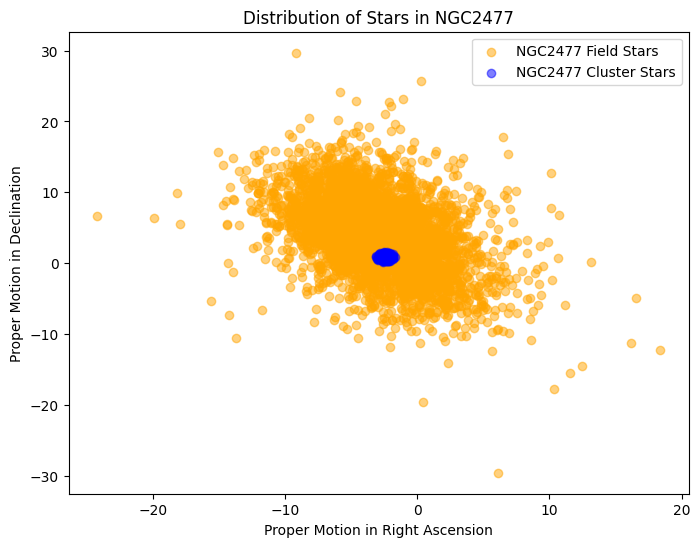

NGC2477: Total number of member stars = 1354
Component 1: Mean RA: 118.0485687818915, Dec: -38.53870148458533, pmRA: -2.4219437351285036, pmDec: 0.9014511813409989, r_med_geo: 1354.0358032311353
Dispersion RA: 0.2164597451861228, Dec: 0.1814274593400355, pmRA: 0.17508464189326348, pmDec: 0.17942085149312664, r_med_geo: 34.94122443913747
Component 2: Mean RA: 116.37935804335164, Dec: -37.96257494404659, pmRA: -2.7872373687744285, pmDec: 3.89636202301523, r_med_geo: 1325.1887773132132
Dispersion RA: 1.2595111303391038, Dec: 1.0087910626460914, pmRA: 3.522332830593149, pmDec: 4.8307057600632515, r_med_geo: 43.49033700630158



In [ ]:
clusters = {
    'NGC2451A': (100, 250),  # range in parsecs
    'NGC2451B': (300, 450),
    'NGC2477': (1250, 1400)
}

# This dictionary defines the approximate distance ranges for each cluster based on prior analysis.

cluster_results = {}

# Initializes an empty dictionary to store the results from the Gaussian Mixture Model (GMM) for each cluster

for cluster, (lower_bound, upper_bound) in clusters.items():
    subset = clean2DF[(clean2DF['r_med_geo'] >= lower_bound) & (clean2DF['r_med_geo'] <= upper_bound)]

    # This loop iterates through each cluster defined in the clusters dictionary, using the cluster's name and distance range.

    # Fit GMM with two components: one for the cluster and one for field stars
    gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
    gmm.fit(subset[['ra', 'dec', 'pmra', 'pmdec', 'r_med_geo']])
    labels = gmm.predict(subset[['ra', 'dec', 'pmra', 'pmdec', 'r_med_geo']])

    # Initializes a Gaussian Mixture Model with two components—one for the cluster stars and one for field stars.

    # Identify the cluster component
    cluster_label = np.argmin([np.std(subset['r_med_geo'][labels == i]) for i in range(2)])
    num_cluster_members = (labels == cluster_label).sum()  # Count of cluster members

    # Identifies which of the two components corresponds to the cluster by comparing their standard deviations in the r_med_geo column.
    # The component with the lower standard deviation is assumed to be the cluster because it should be denser.

    cluster_results[cluster] = {
        'means': gmm.means_,
        'covariances': gmm.covariances_,
        'labels': labels,
        'num_members': num_cluster_members  # Storing the number of member stars
    }

    # Stores the means, covariances, and labels (cluster assignments) from the GMM in the cluster_results dictionary under the respective cluster's key.

    # Plot results
    plt.figure(figsize=(8, 6))
    field_members = subset[labels != cluster_label]
    cluster_members = subset[labels == cluster_label]
    plt.scatter(field_members['pmra'], field_members['pmdec'], color='orange', alpha=0.5, label=f'{cluster} Field Stars')
    plt.scatter(cluster_members['pmra'], cluster_members['pmdec'], color='blue', alpha=0.5, label=f'{cluster} Cluster Stars')
    plt.title(f'Distribution of Stars in {cluster}')
    plt.xlabel('Proper Motion in Right Ascension')
    plt.ylabel('Proper Motion in Declination')
    plt.legend()
    plt.show()

    # Print means, covariances, and total number of members
    print(f"{cluster}: Total number of member stars = {num_cluster_members}")
    for i, (mean, cov) in enumerate(zip(gmm.means_, gmm.covariances_)):
        ra, dec, pmra, pmdec, r_med_geo = mean
        ra_disp, dec_disp, pmra_disp, pmdec_disp, r_med_geo_disp = np.sqrt(np.diag(cov))
        print(f"Component {i+1}: Mean RA: {ra}, Dec: {dec}, pmRA: {pmra}, pmDec: {pmdec}, r_med_geo: {r_med_geo}")
        print(f"Dispersion RA: {ra_disp}, Dec: {dec_disp}, pmRA: {pmra_disp}, pmDec: {pmdec_disp}, r_med_geo: {r_med_geo_disp}")
    print()

# Part 3: Cluster colour magnitude diagrams


With knowledge of which stars are most likely to be members of the three star clusters in this field, you can now plot the colour-magnitude diagrams (CMD; $G_{BP} - G_{RP}$ vs $M_G$)  separately for the cluster and non-cluster stars. When determining the absolute G-band magnitude, $M_G$, for the cluster stars you can use the mean distance to the cluster as determined above.

<font color='blue'> **(3a)** Plot the CMDs for the three clusters. Explain any differences you see in the CMDs.</font>

<font color='blue'> **(3b)** Plot the CMDs for the field sample of stars restricted to within a distance 1000pc. Compare the field CMD with the CMDs for NGC2451A and NGC2451B. Explain any differences.</font>

<ipython-input-27-4a58d5c53904>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean2DF['M_G'] = clean2DF['phot_g_mean_mag'] + 5 - 5 * np.log10(clean2DF['r_med_geo'])


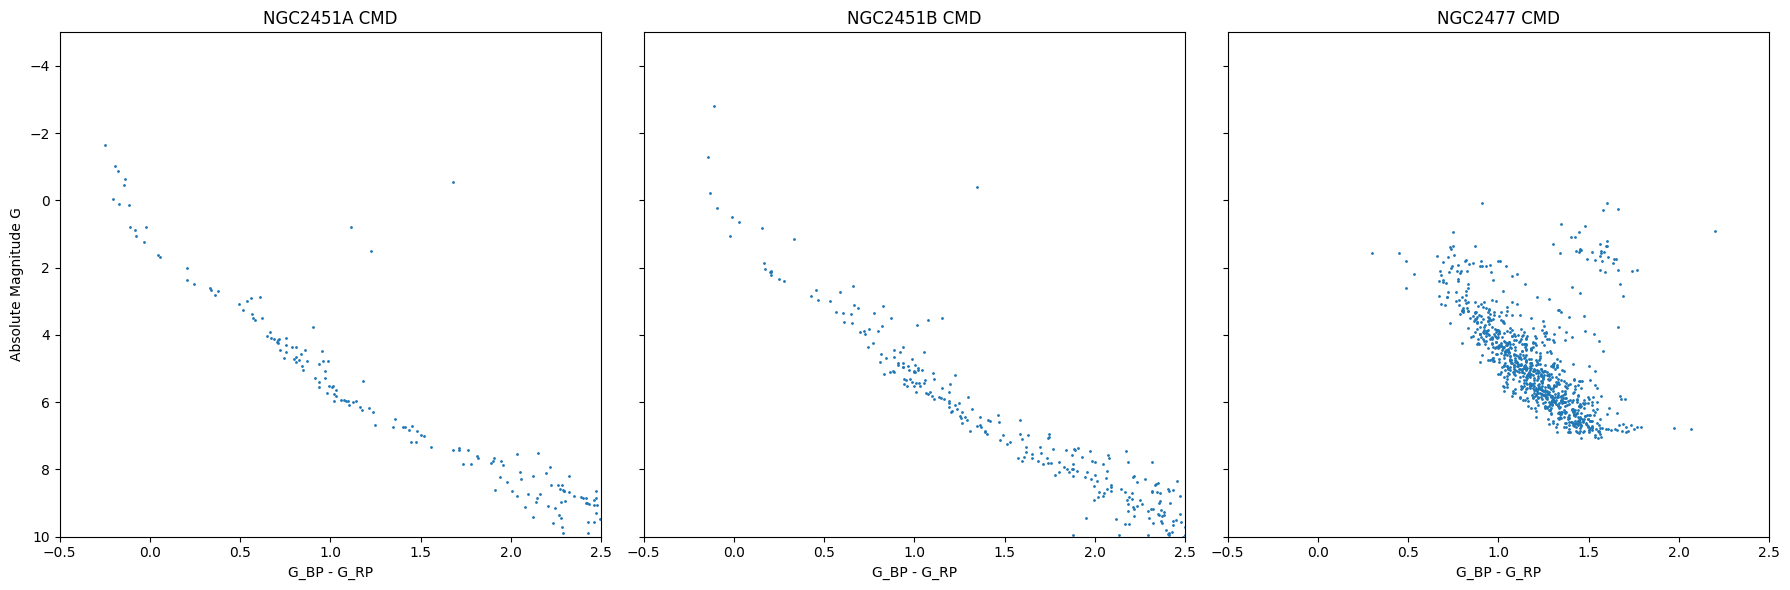

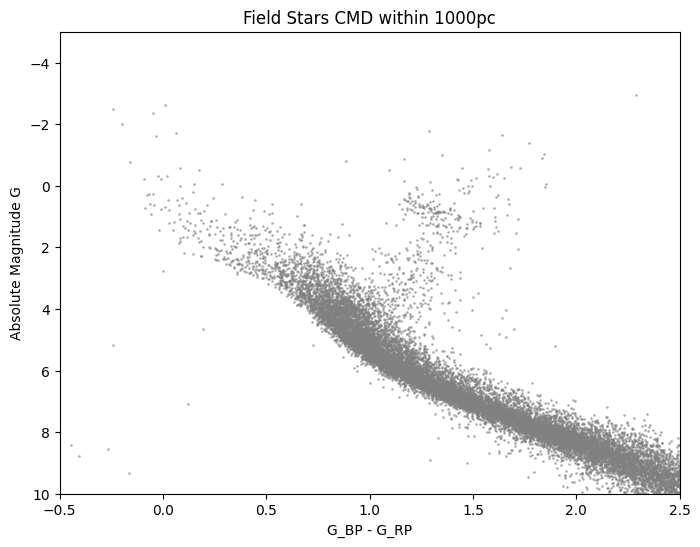

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the mean distances for the clusters
cluster_distances = {
    'NGC2451A': 191.56,  # in parsecs
    'NGC2451B': 370,
    'NGC2477': 1354
}

# Defines a dictionary with the mean distances to each cluster, used for calculating absolute magnitudes

# Create a mask for each cluster using the distance ranges
masks = {
    cluster: (clean2DF['r_med_geo'] >= dist - 10) & (clean2DF['r_med_geo'] <= dist + 10)
    for cluster, dist in cluster_distances.items()
}

# Generates Boolean masks for each cluster based on proximity to the defined mean distance (within +/- 10 pc for this example)

# Calculate absolute magnitude for all stars
clean2DF['M_G'] = clean2DF['phot_g_mean_mag'] + 5 - 5 * np.log10(clean2DF['r_med_geo'])

# Plot CMD for each cluster
fig, axs = plt.subplots(1, len(cluster_distances), figsize=(18, 6), sharey=True) # Set up subplots for each cluster to compare their CMDs on the same scale.
for ax, (cluster, mask) in zip(axs, masks.items()):
    cluster_data = clean2DF[mask]
    ax.scatter(cluster_data['phot_bp_mean_mag'] - cluster_data['phot_rp_mean_mag'], cluster_data['M_G'], s=1)
    ax.invert_yaxis()  # Brighter stars have lower magnitudes
    ax.set_title(f'{cluster} CMD')
    ax.set_xlabel('G_BP - G_RP')
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(10, -5)

    # Loop through each cluster mask and plot the Color-Magnitude Diagram for cluster members.

axs[0].set_ylabel('Absolute Magnitude G')
plt.tight_layout()
plt.show()

# Additionally, to plot CMD for the field stars within 1000pc and compare
field_stars = clean2DF[(clean2DF['r_med_geo'] <= 1000) & ~np.any([masks[cluster] for cluster in masks], axis=0)]
plt.figure(figsize=(8, 6))
plt.scatter(field_stars['phot_bp_mean_mag'] - field_stars['phot_rp_mean_mag'], field_stars['M_G'], s=1, color='gray', alpha=0.5)
plt.gca().invert_yaxis()
plt.title('Field Stars CMD within 1000pc')
plt.xlabel('G_BP - G_RP')
plt.ylabel('Absolute Magnitude G')
plt.xlim(-0.5, 2.5)
plt.ylim(10, -5)
plt.show()

# Identify field stars within 1000 pc and plot their CMD separately